# Model Evaluation for Income Inequality Predictions

This notebook evaluates the performance of our models for predicting income inequality metrics:
- GINI coefficient
- Top 10% wealth share
- Bottom 10% wealth share

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import json
import os
import warnings

# Suppress specific pandas warning about grouping
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')
# Suppress the Seaborn palette warning
warnings.filterwarnings('ignore', message="Passing `palette` without assigning `hue` is deprecated")

# Set the aesthetic style of the plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Load the Prediction Data

We'll load both the regular and best model predictions for each metric.

In [29]:
# Define the metrics
metrics = ['GINI', 'top10pct_wealth_share', 'bottom10pct_wealth_share']

# Create dictionaries to store the dataframes
predictions = {}
best_predictions = {}

# Load the prediction data
for metric in metrics:
    predictions[metric] = pd.read_csv(f'output/predictions/xgb_predictions_{metric}.csv')
    best_predictions[metric] = pd.read_csv(f'output/predictions/xgb_best_predictions_{metric}.csv')
    
    # Display the first few rows
    print(f"Regular predictions for {metric}:")
    display(predictions[metric].head())
    
    print(f"Best model predictions for {metric}:")
    display(best_predictions[metric].head())

Regular predictions for GINI:


Actual  Predicted
0    34.0  33.702740
1    47.4  37.093470
2    33.4  33.174920
3    36.7  37.136364
4    52.3  47.951650

Best model predictions for GINI:


Actual  Predicted
0    34.0  33.256138
1    47.4  39.451378
2    33.4  33.695270
3    36.7  37.220610
4    52.3  51.540794

Regular predictions for top10pct_wealth_share:


Actual  Predicted
0    25.4  25.156800
1    36.9  29.114310
2    25.8  24.634174
3    26.0  25.007338
4    40.2  39.721375

Best model predictions for top10pct_wealth_share:


Actual  Predicted
0    25.4  25.080130
1    36.9  30.396393
2    25.8  25.078585
3    26.0  26.129725
4    40.2  39.697056

Regular predictions for bottom10pct_wealth_share:


Actual  Predicted
0     2.7   2.873019
1     1.8   2.763535
2     2.9   3.008634
3     2.8   3.043082
4     1.5   1.763842

Best model predictions for bottom10pct_wealth_share:


Actual  Predicted
0     2.7   2.719647
1     1.8   2.814764
2     2.9   2.951713
3     2.8   3.006801
4     1.5   1.551752

## Calculate Evaluation Metrics

Let's calculate several evaluation metrics for each model and metric combination.

In [30]:
def evaluate_predictions(actual, predicted):
    """Calculate evaluation metrics for model predictions."""
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    
    # Calculate percentage error metrics
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape
    }

# Create a dataframe to store evaluation results
results = []

for metric in metrics:
    # Regular model evaluation
    reg_eval = evaluate_predictions(predictions[metric]['Actual'], predictions[metric]['Predicted'])
    reg_eval['Metric'] = metric
    reg_eval['Model'] = 'Regular'
    results.append(reg_eval)
    
    # Best model evaluation
    best_eval = evaluate_predictions(best_predictions[metric]['Actual'], best_predictions[metric]['Predicted'])
    best_eval['Metric'] = metric
    best_eval['Model'] = 'Best'
    results.append(best_eval)

# Convert to dataframe and display
results_df = pd.DataFrame(results)
results_df = results_df[['Metric', 'Model', 'RMSE', 'MAE', 'R²', 'MAPE (%)']]
results_df

Metric    Model      RMSE       MAE        R²   MAPE (%)
0                      GINI  Regular  3.083538  2.112406  0.883888   5.526837
1                      GINI     Best  2.614829  1.555443  0.916504   4.013426
2     top10pct_wealth_share  Regular  2.827377  1.823562  0.847043   5.980095
3     top10pct_wealth_share     Best  2.490099  1.373638  0.881359   4.410629
4  bottom10pct_wealth_share  Regular  0.324350  0.238397  0.899007  14.074680
5  bottom10pct_wealth_share     Best  0.272710  0.181994  0.928605   9.728746

## Visualize Model Performance

Let's create some visualizations to better understand model performance.

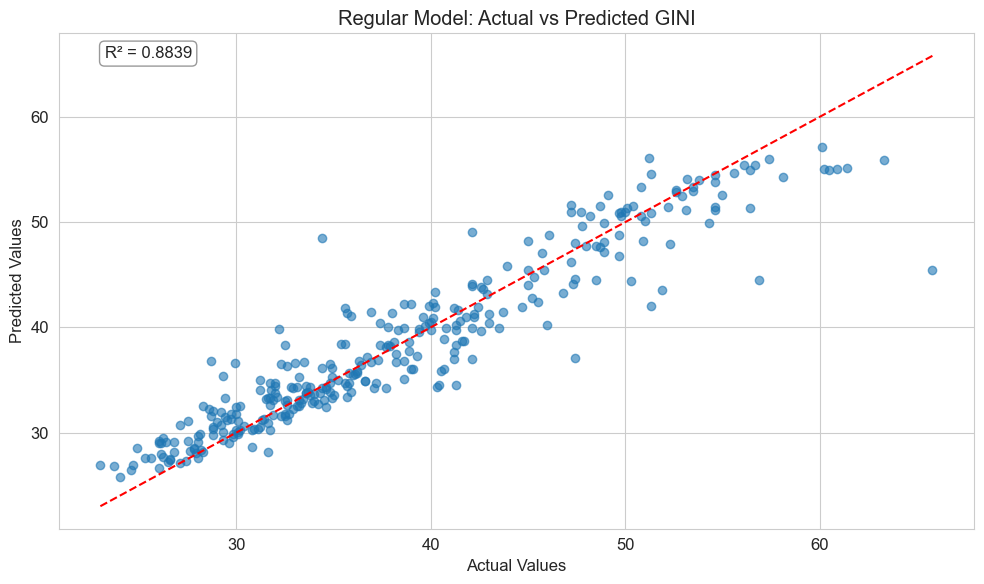

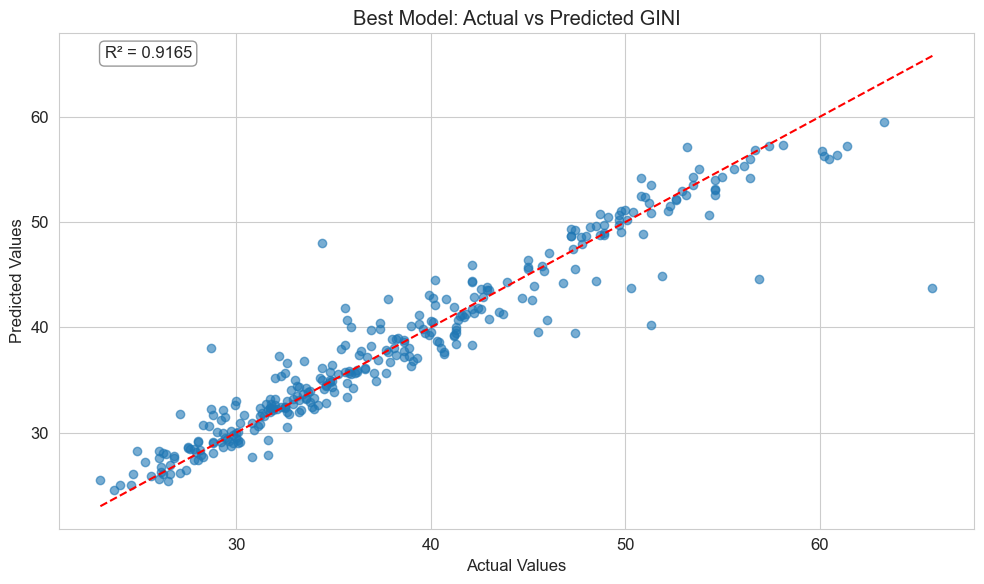

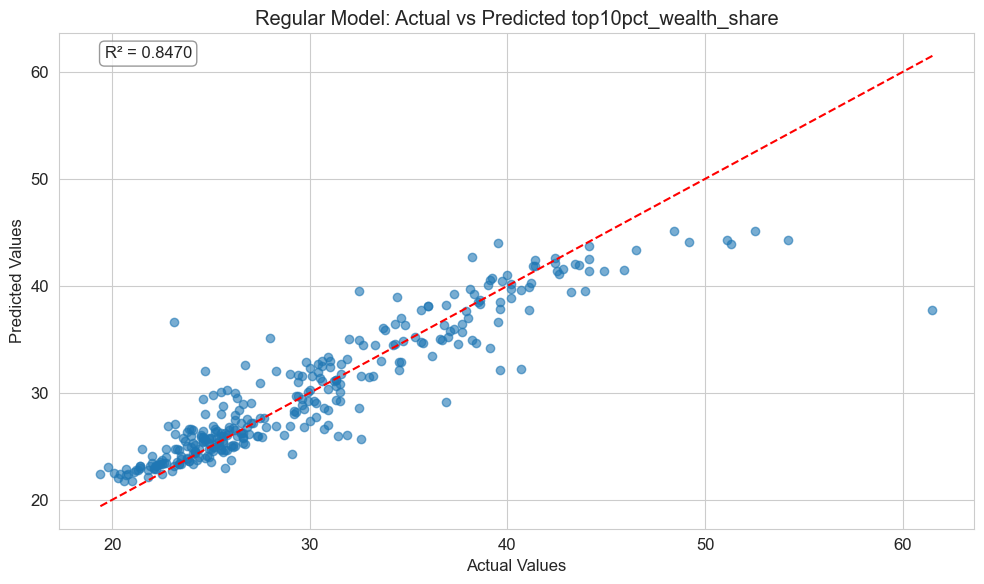

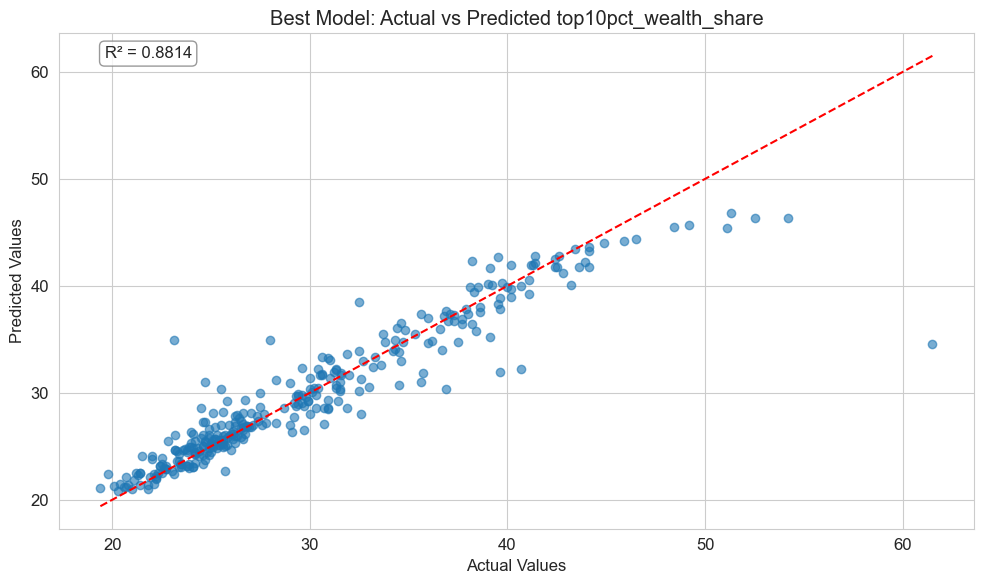

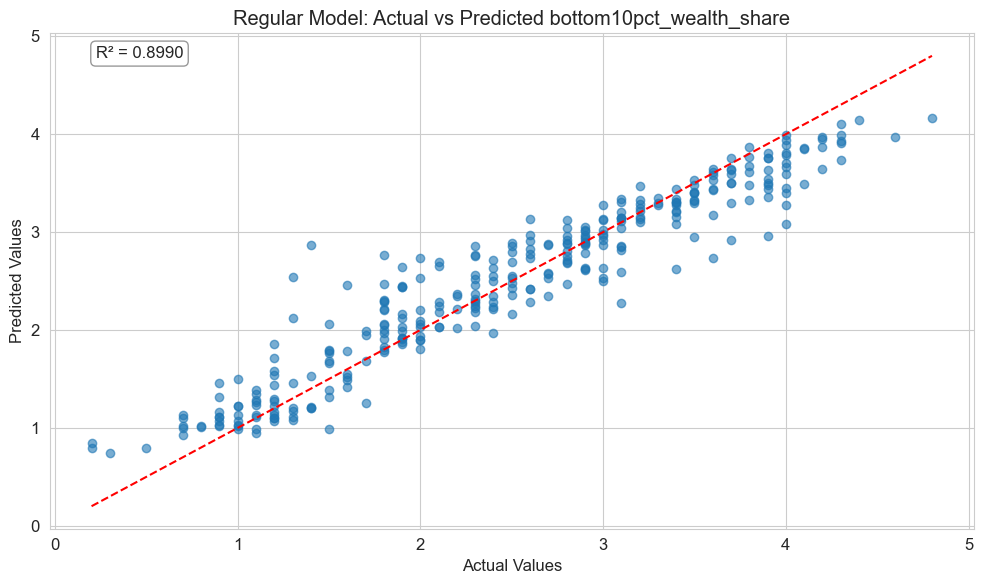

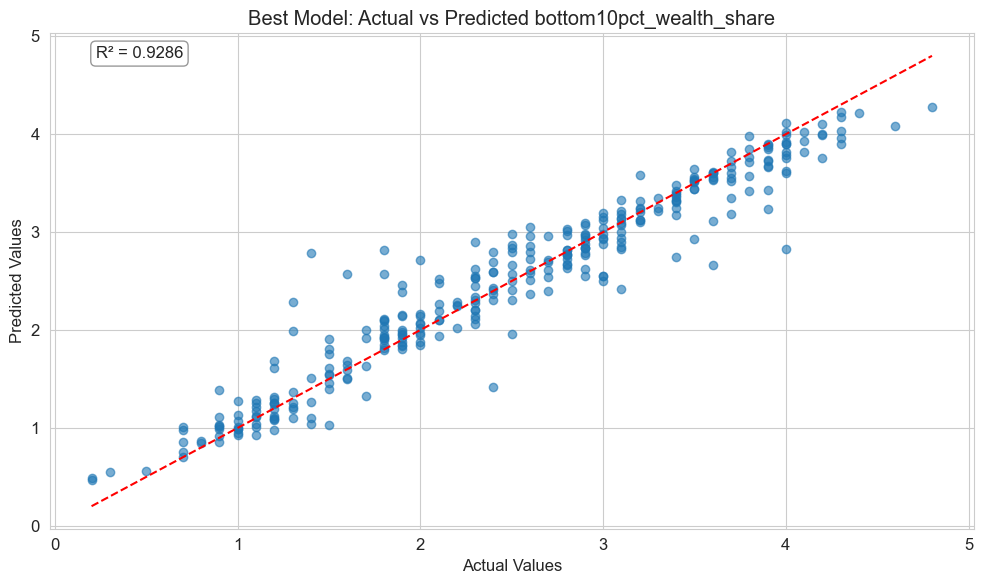

In [31]:
# Function to create scatter plot of actual vs predicted values
def plot_actual_vs_predicted(actual, predicted, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predicted, alpha=0.6)
    
    # Add perfect prediction line
    min_val = min(actual.min(), predicted.min())
    max_val = max(actual.max(), predicted.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.grid(True)
    
    # Add R² value to plot
    r2 = r2_score(actual, predicted)
    plt.annotate(f'R² = {r2:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    return plt.gcf()

# Create and display scatter plots for each metric and model
for metric in metrics:
    # Regular model
    plot_actual_vs_predicted(
        predictions[metric]['Actual'], 
        predictions[metric]['Predicted'],
        f'Regular Model: Actual vs Predicted {metric}'
    )
    plt.show()
    
    # Best model
    plot_actual_vs_predicted(
        best_predictions[metric]['Actual'], 
        best_predictions[metric]['Predicted'],
        f'Best Model: Actual vs Predicted {metric}'
    )
    plt.show()

## Residual Analysis

Let's analyze the residuals (prediction errors) to check for patterns or biases.

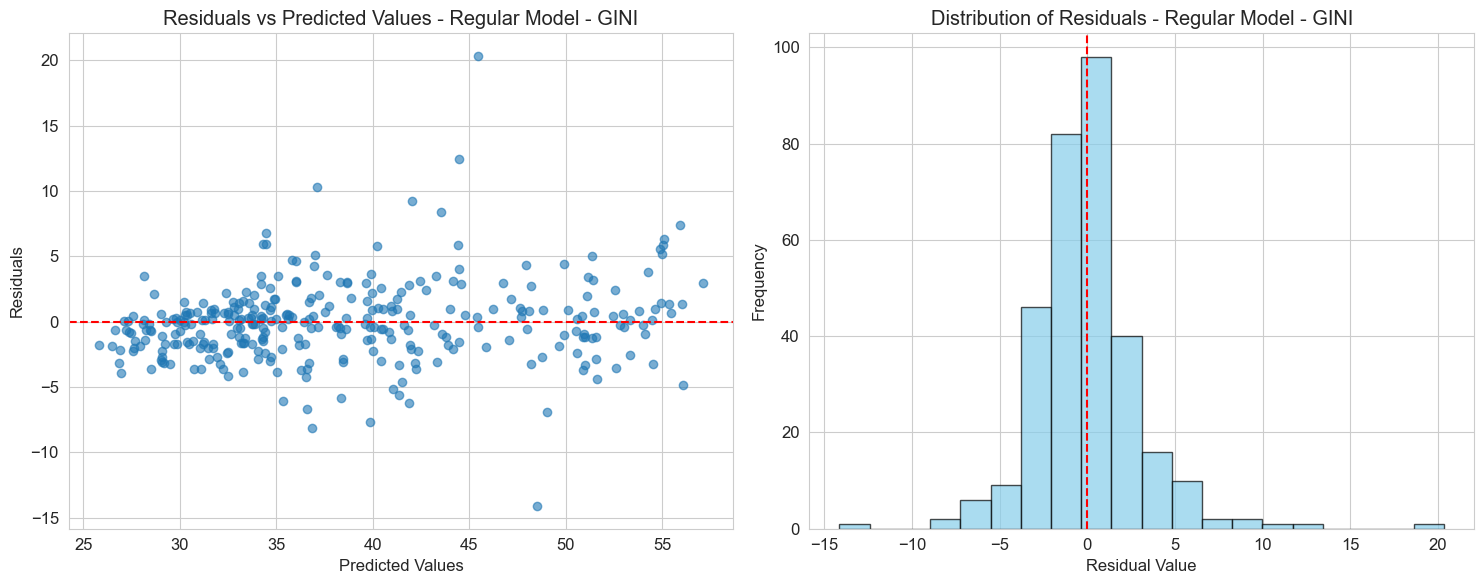

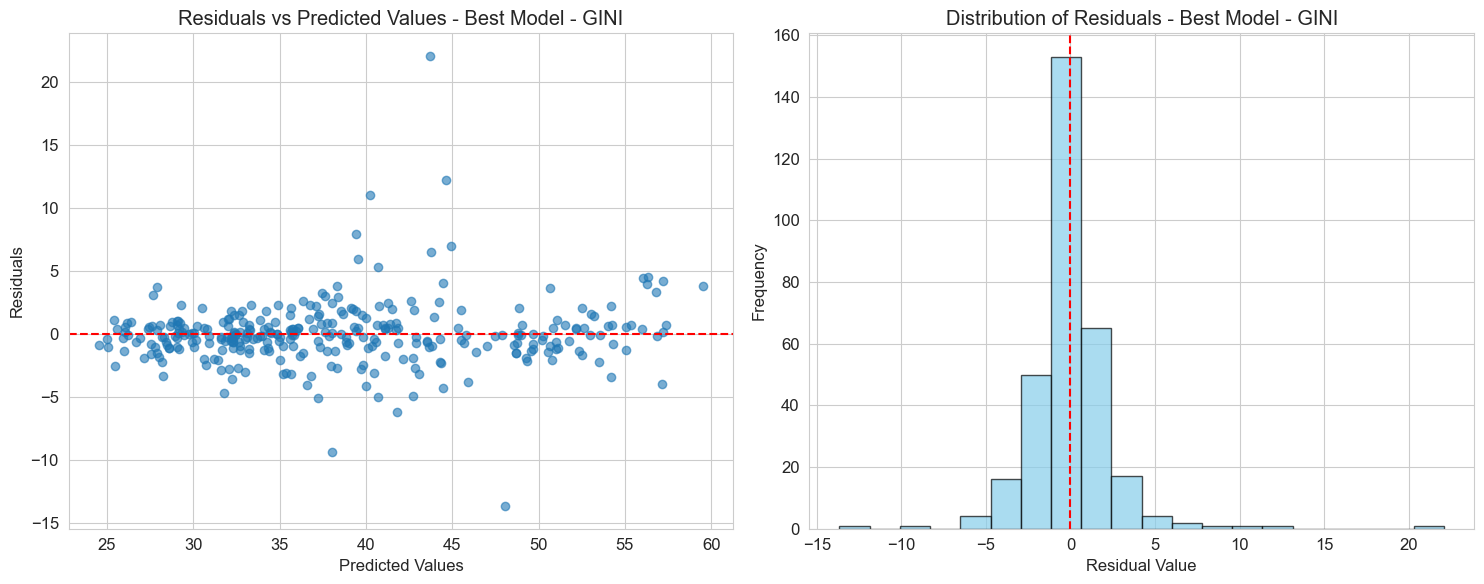

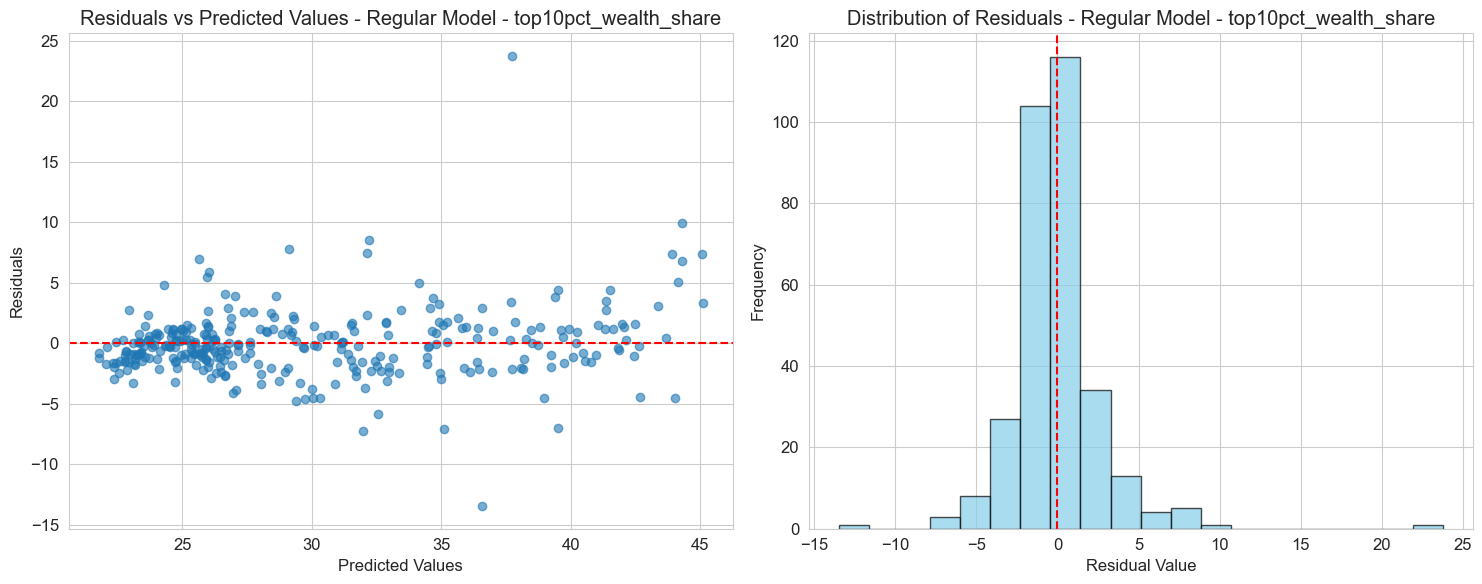

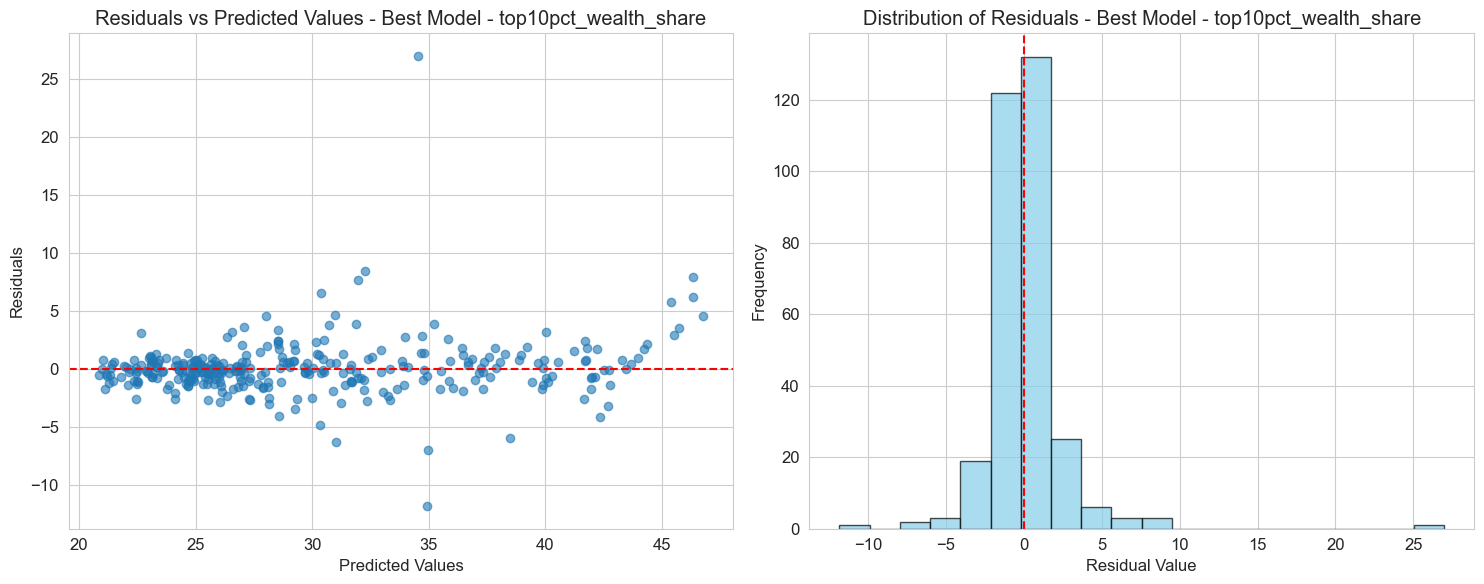

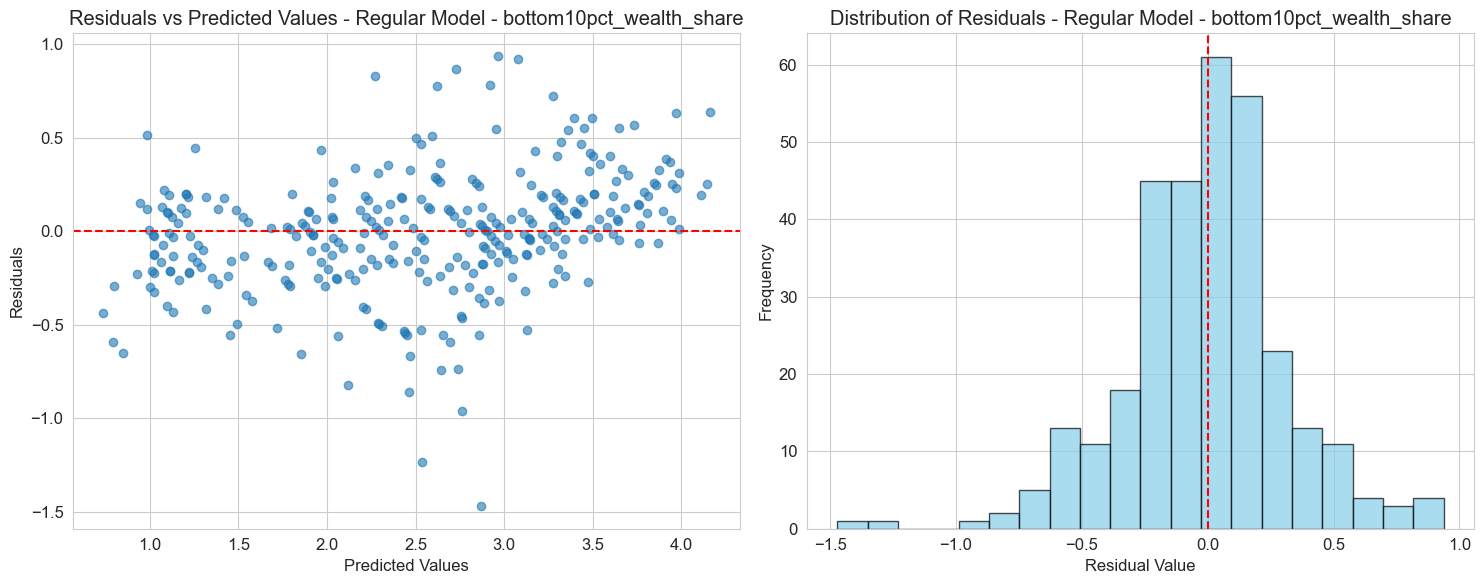

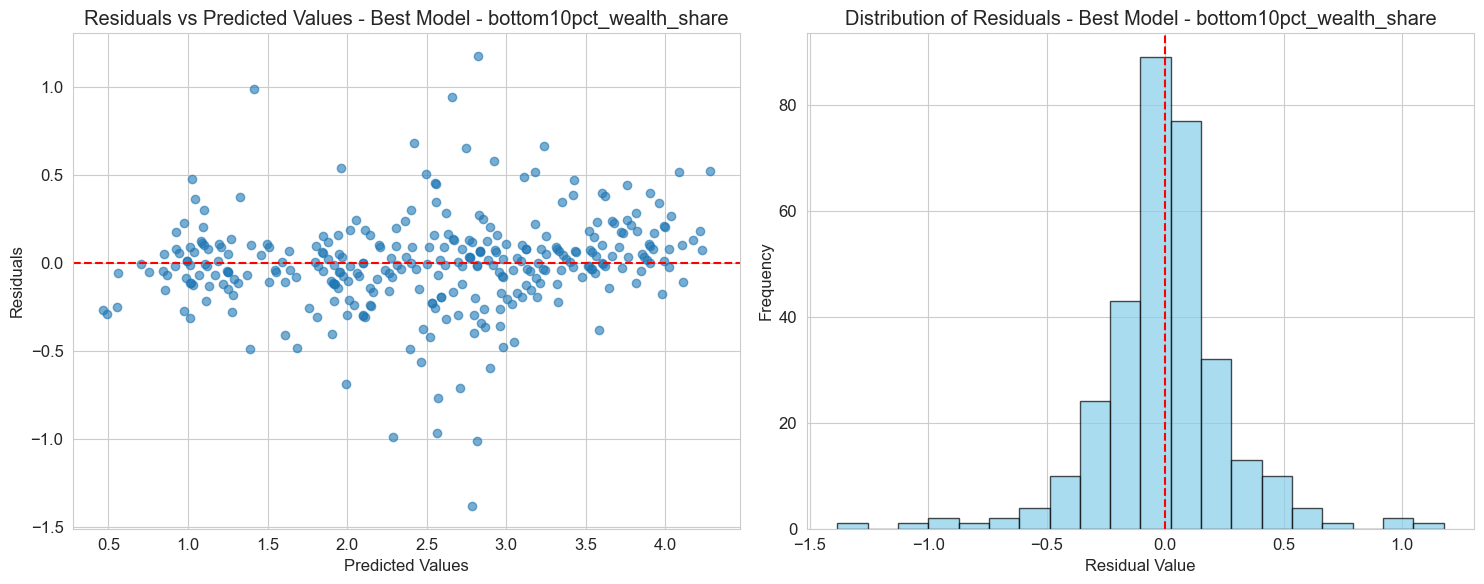

In [32]:
# Function to plot residuals
def plot_residuals(actual, predicted, title):
    residuals = actual - predicted
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Residuals vs predicted values
    ax1.scatter(predicted, residuals, alpha=0.6)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_xlabel('Predicted Values')
    ax1.set_ylabel('Residuals')
    ax1.set_title(f'Residuals vs Predicted Values - {title}')
    ax1.grid(True)
    
    # Histogram of residuals
    ax2.hist(residuals, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(x=0, color='r', linestyle='--')
    ax2.set_xlabel('Residual Value')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Distribution of Residuals - {title}')
    ax2.grid(True)
    
    plt.tight_layout()
    return fig

# Create and display residual plots for each metric and model
for metric in metrics:
    # Regular model
    plot_residuals(
        predictions[metric]['Actual'], 
        predictions[metric]['Predicted'],
        f'Regular Model - {metric}'
    )
    plt.show()
    
    # Best model
    plot_residuals(
        best_predictions[metric]['Actual'], 
        best_predictions[metric]['Predicted'],
        f'Best Model - {metric}'
    )
    plt.show()

## Model Parameters Comparison

Let's examine the hyperparameters of the best models.

In [33]:
# Load hyperparameters for best models
hyperparams = {}

for metric in metrics:
    # Handle the different file naming convention
    if metric == 'top10pct_wealth_share':
        file_metric = 'top10pct_wealth_share'
    elif metric == 'bottom10pct_wealth_share':
        file_metric = 'bottom10pct_wealth_share'
    else:
        file_metric = metric
        
    hyperparam_path = f'output/models/best_model_params_{file_metric}.json'
    
    try:
        with open(hyperparam_path, 'r') as f:
            hyperparams[metric] = json.load(f)
        print(f"Loaded hyperparameters for {metric}")
    except Exception as e:
        print(f"Error loading hyperparameters for {metric}: {e}")
        hyperparams[metric] = {}

# Display hyperparameters in a nice format
for metric, params in hyperparams.items():
    print(f"\n=== Hyperparameters for {metric} ===\n")
    for param, value in params.items():
        print(f"{param}: {value}")

Loaded hyperparameters for GINI
Loaded hyperparameters for top10pct_wealth_share
Loaded hyperparameters for bottom10pct_wealth_share

=== Hyperparameters for GINI ===

model__colsample_bylevel: 0.9010517491308082
model__colsample_bytree: 0.9395992960433877
model__gamma: 0.6331108417581415
model__learning_rate: 0.08723901599377133
model__max_depth: 5
model__min_child_weight: 5
model__n_estimators: 133
model__reg_alpha: 1.8688165721823782
model__reg_lambda: 1.464786088638586
model__subsample: 0.9228761938728909

=== Hyperparameters for top10pct_wealth_share ===

model__colsample_bylevel: 0.7407960993273509
model__colsample_bytree: 0.9508410181190827
model__gamma: 1.3047560001770928
model__learning_rate: 0.05116466295321231
model__max_depth: 5
model__min_child_weight: 2
model__n_estimators: 170
model__reg_alpha: 0.7575176304276007
model__reg_lambda: 3.4392701633892786
model__subsample: 0.9233807090140386

=== Hyperparameters for bottom10pct_wealth_share ===

model__colsample_bylevel: 0.97

## Feature Importance Analysis

Let's examine the most important features for each model.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

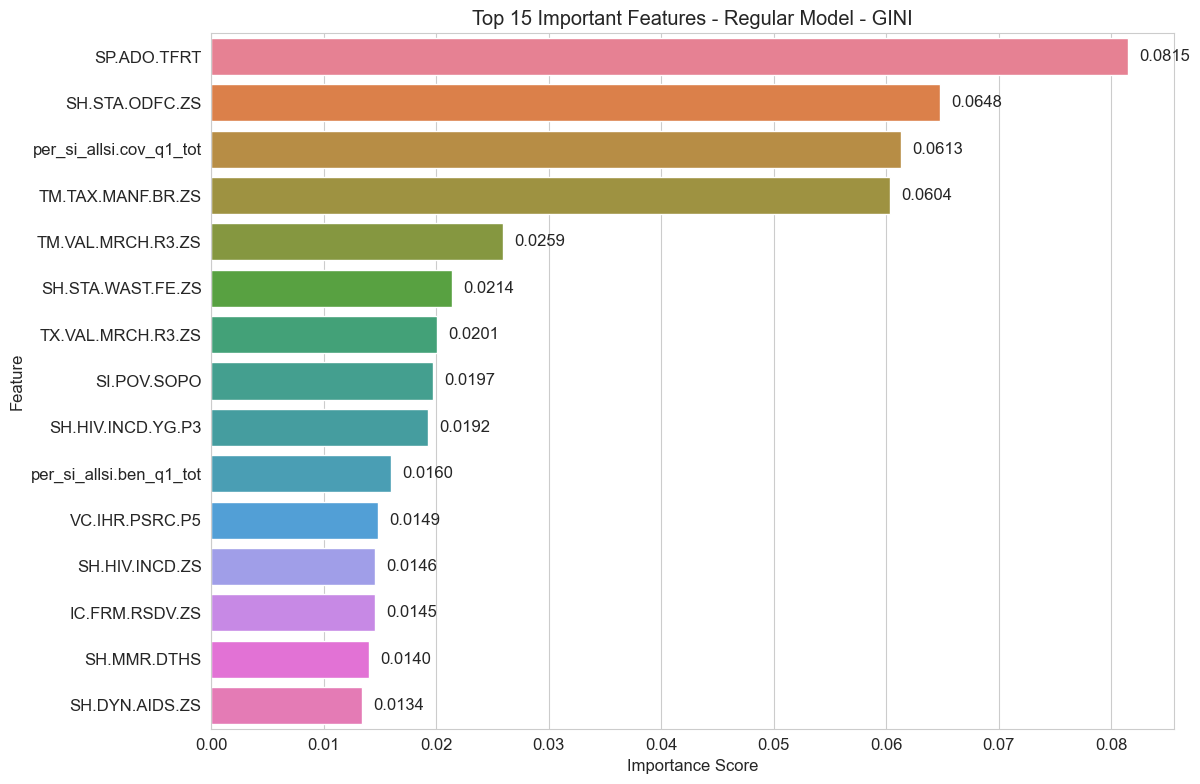

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

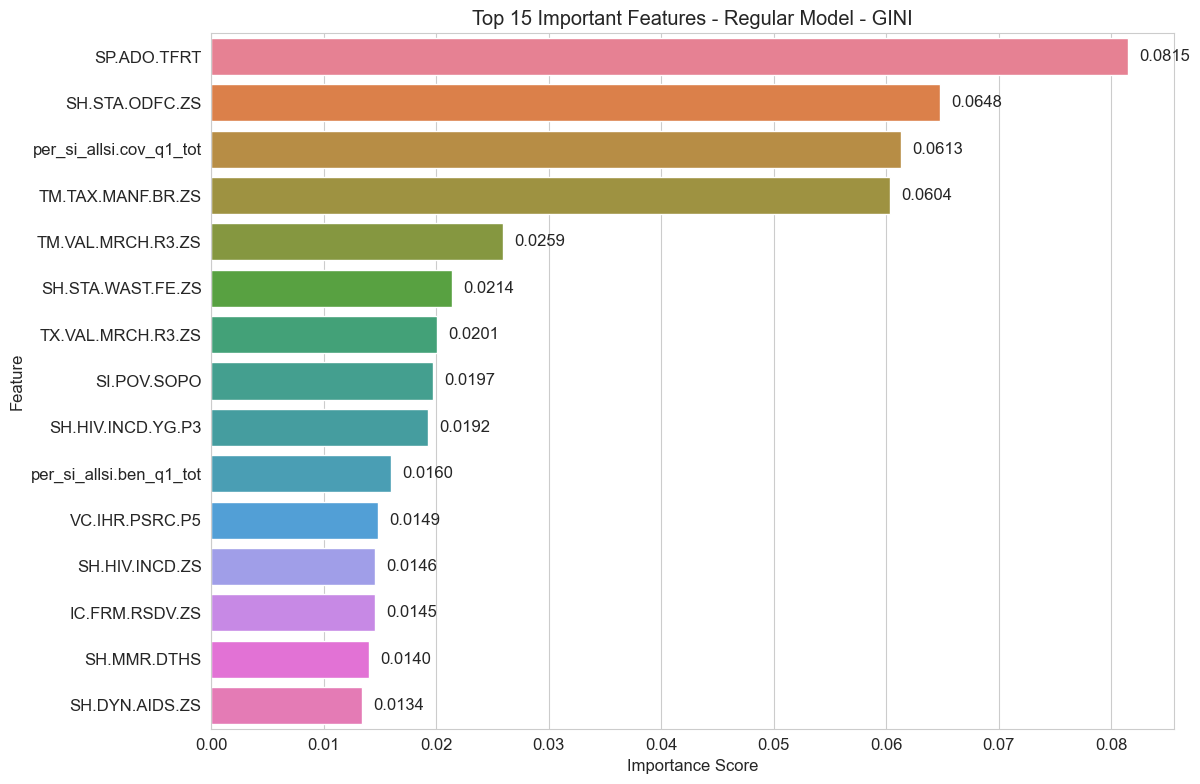

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

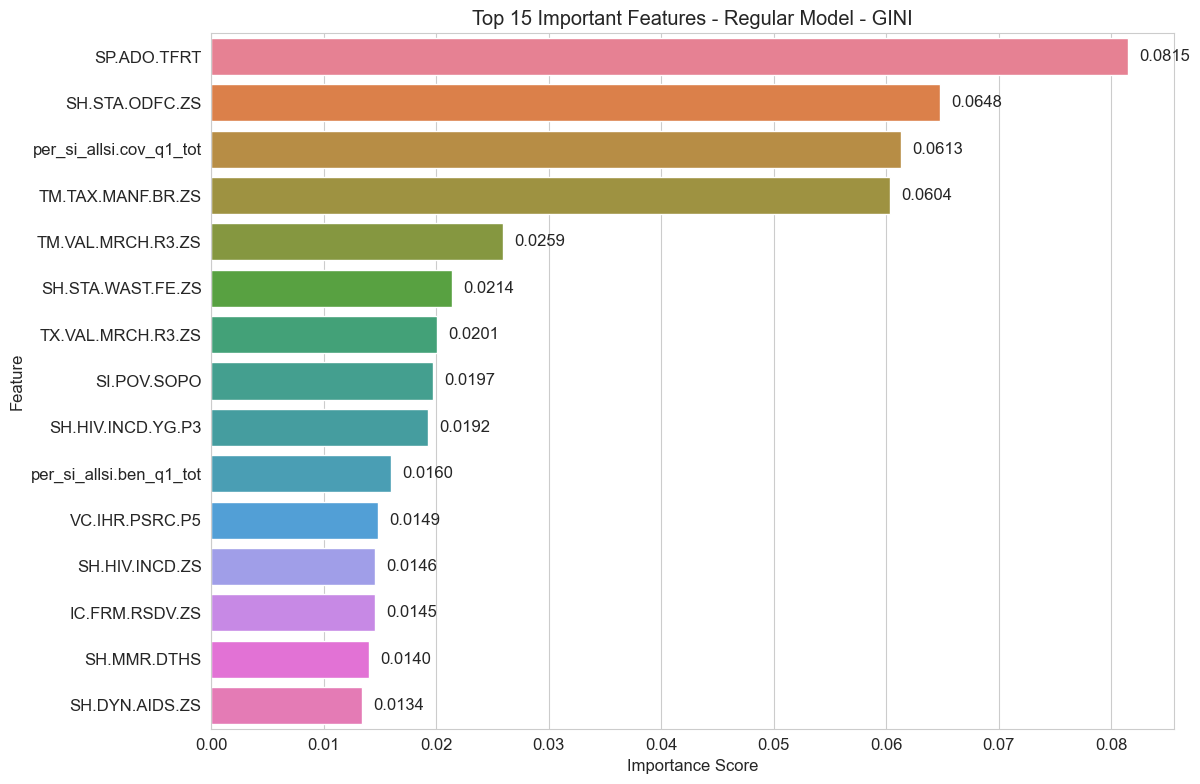

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

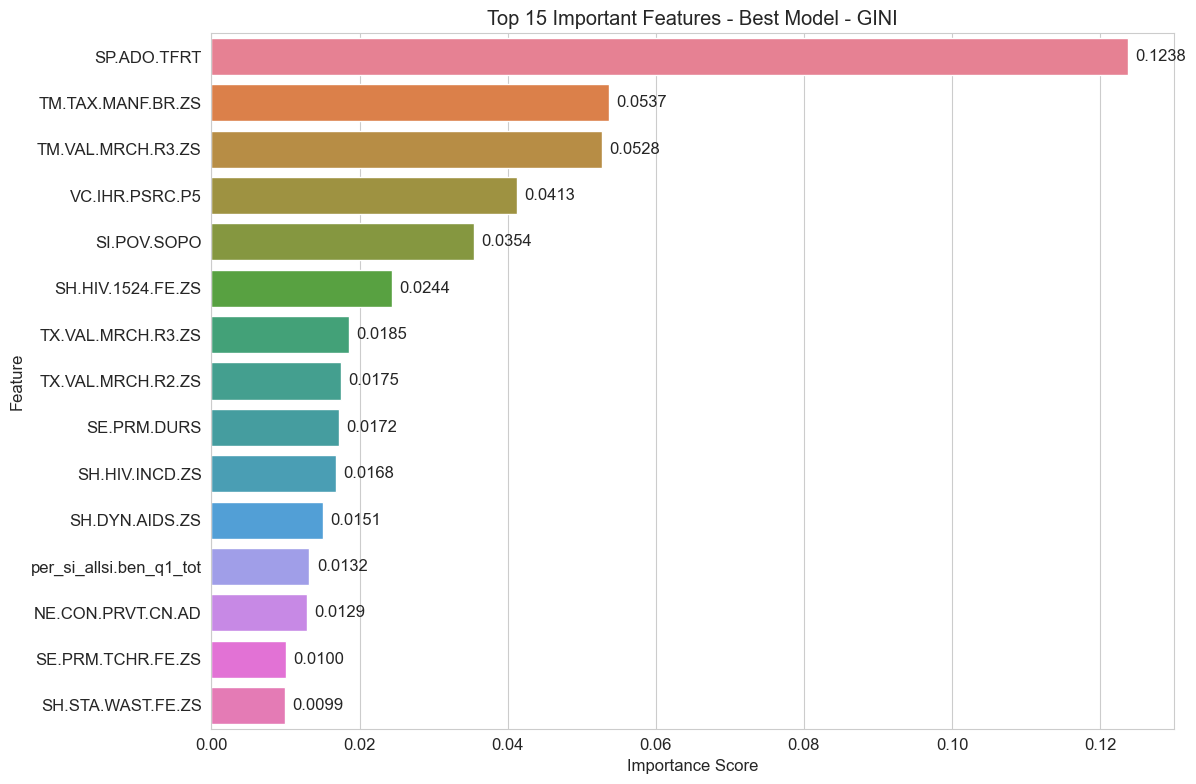

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

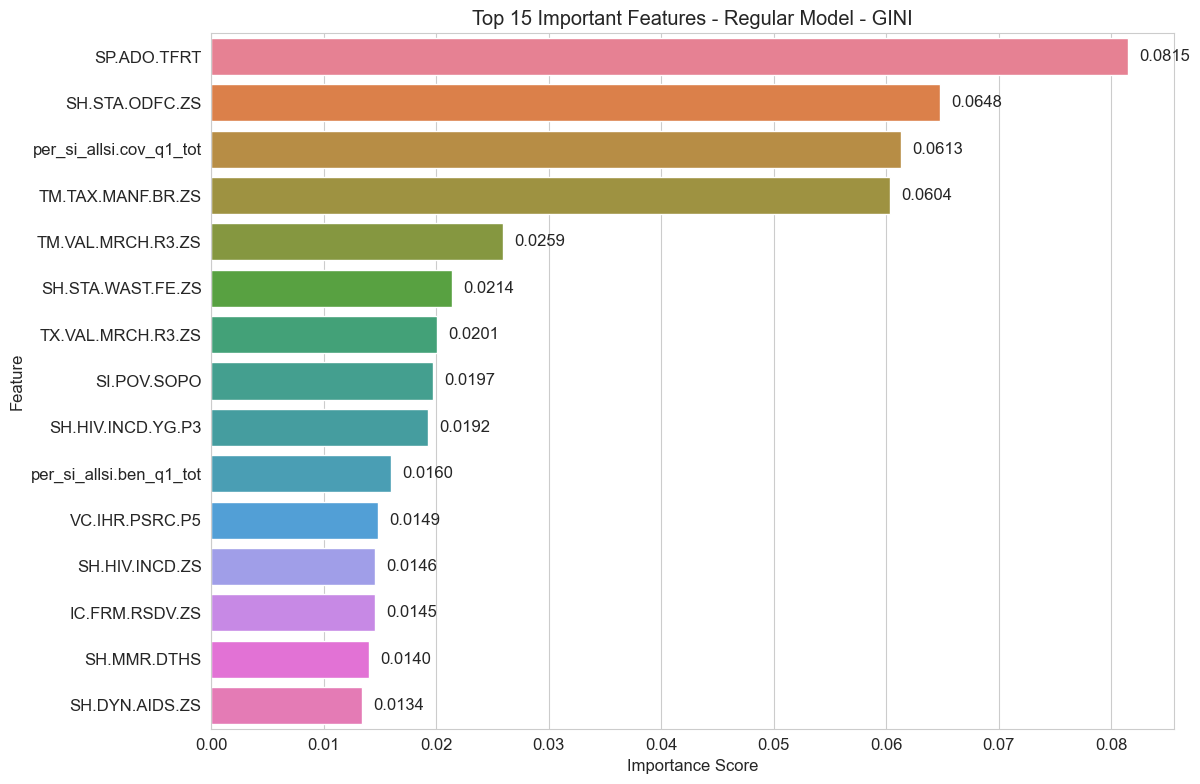

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

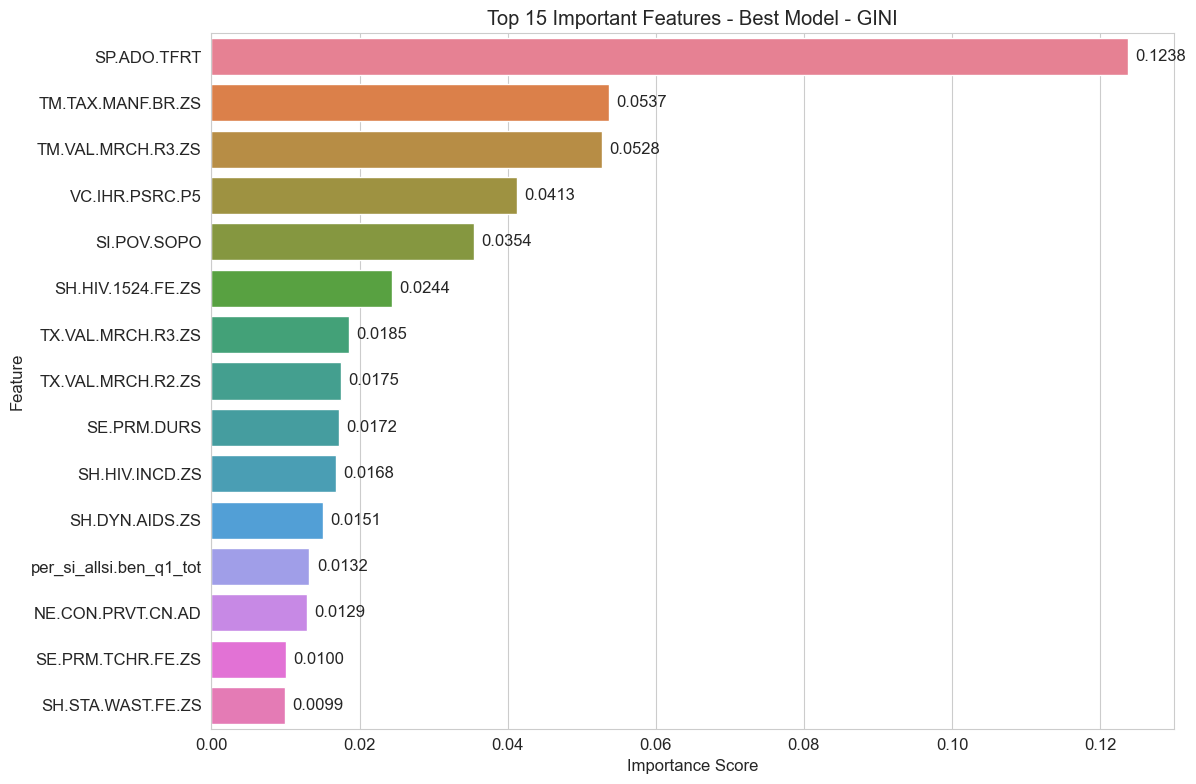

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

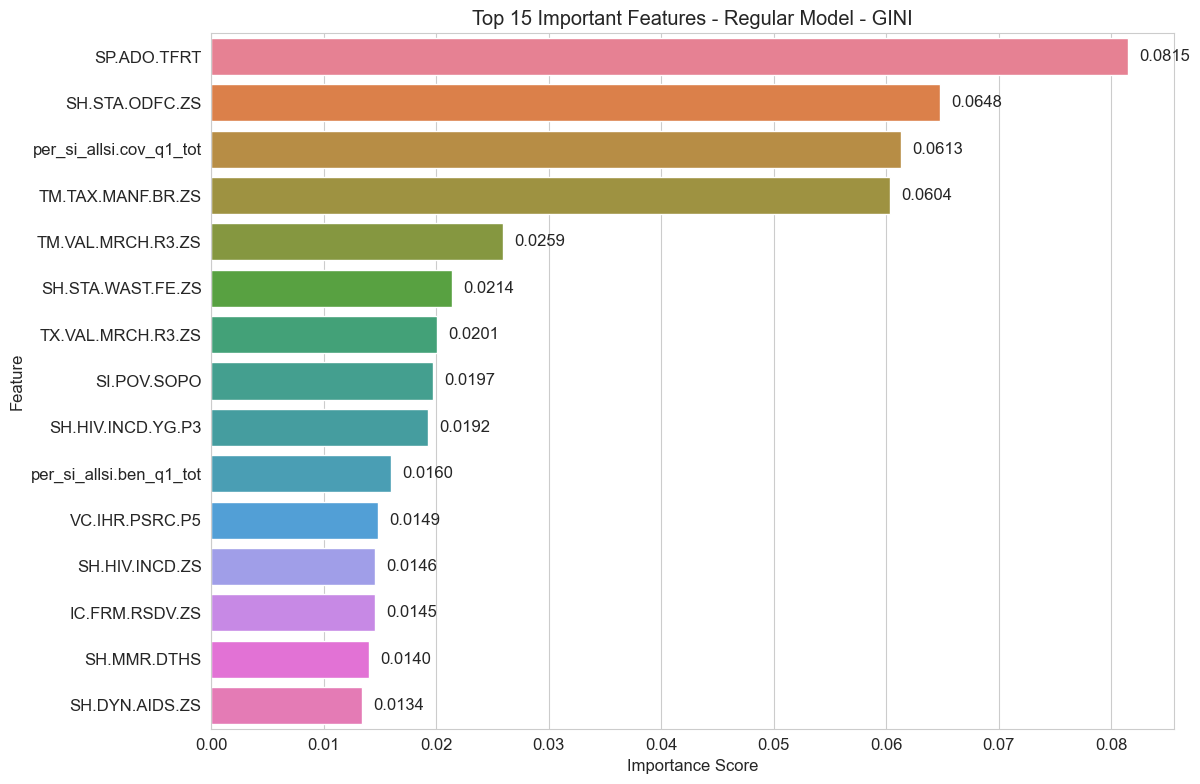

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

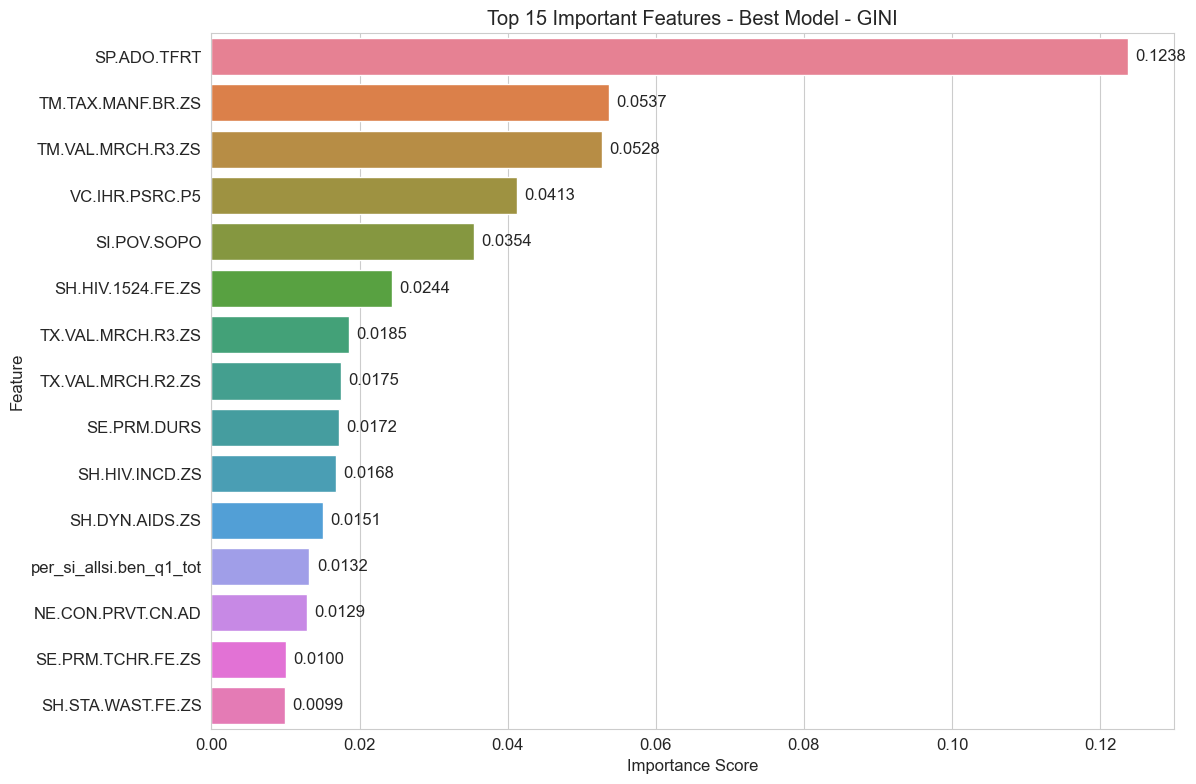

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

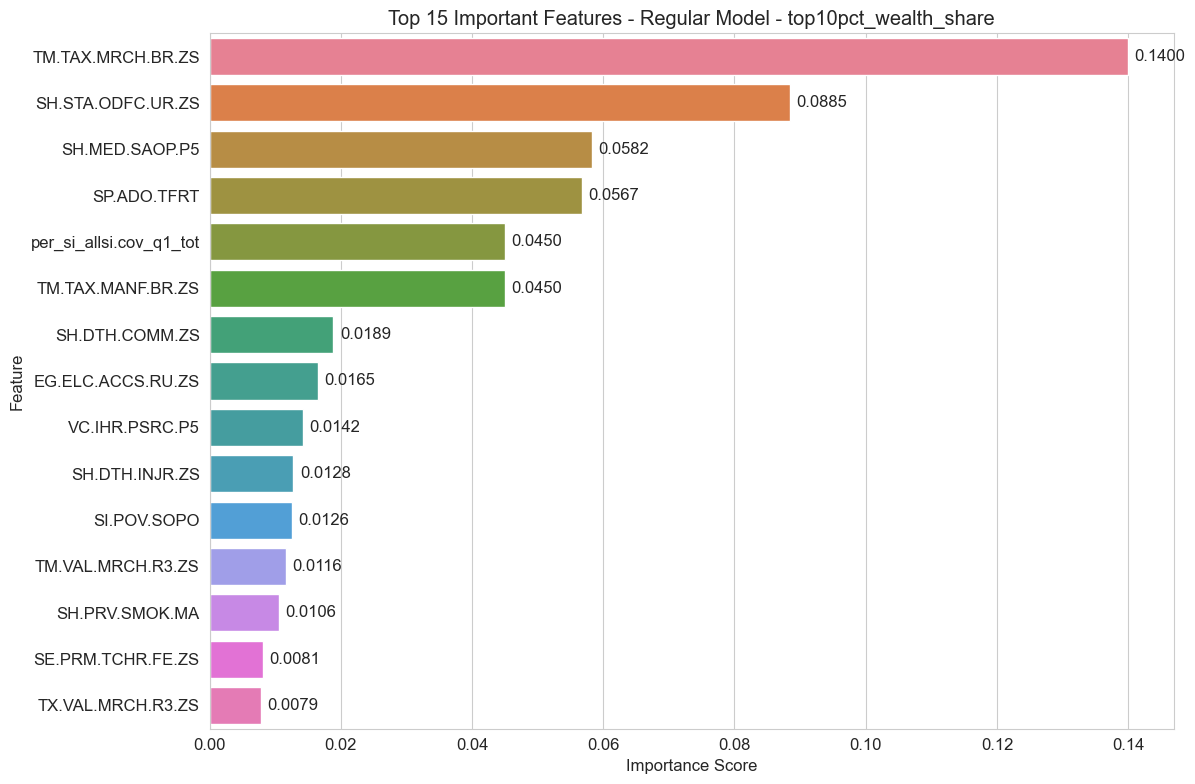

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

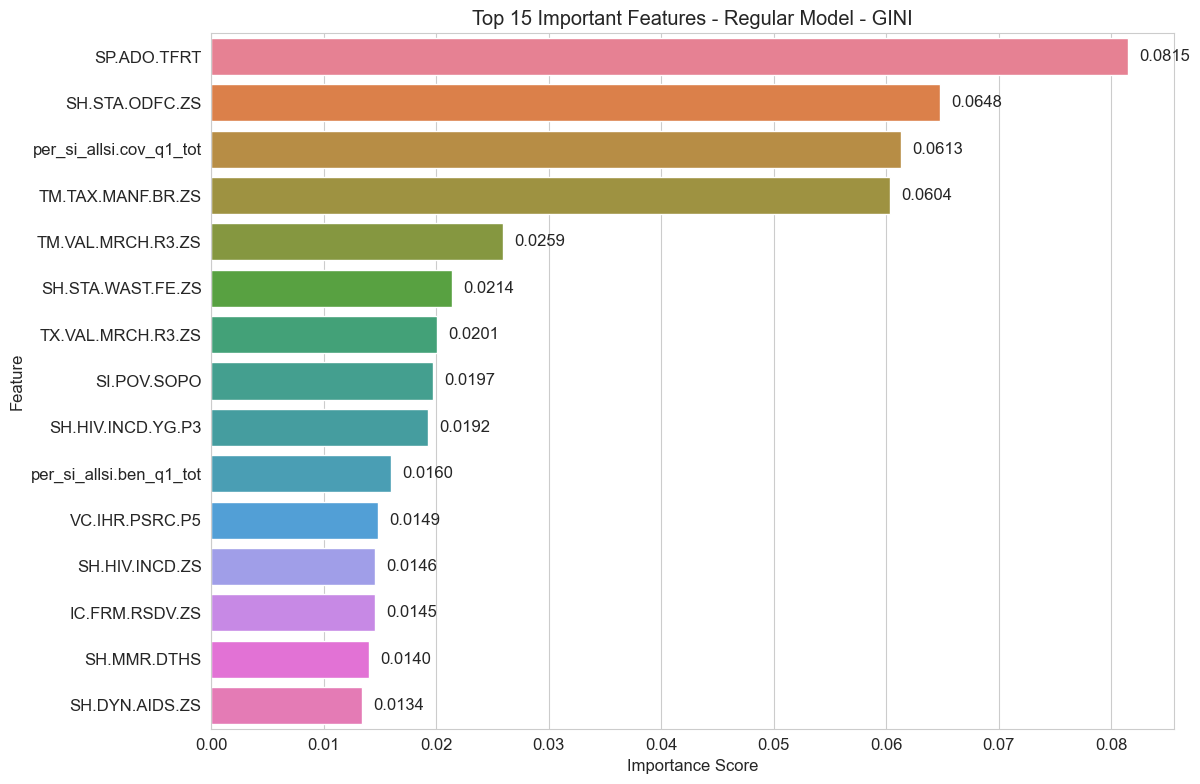

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

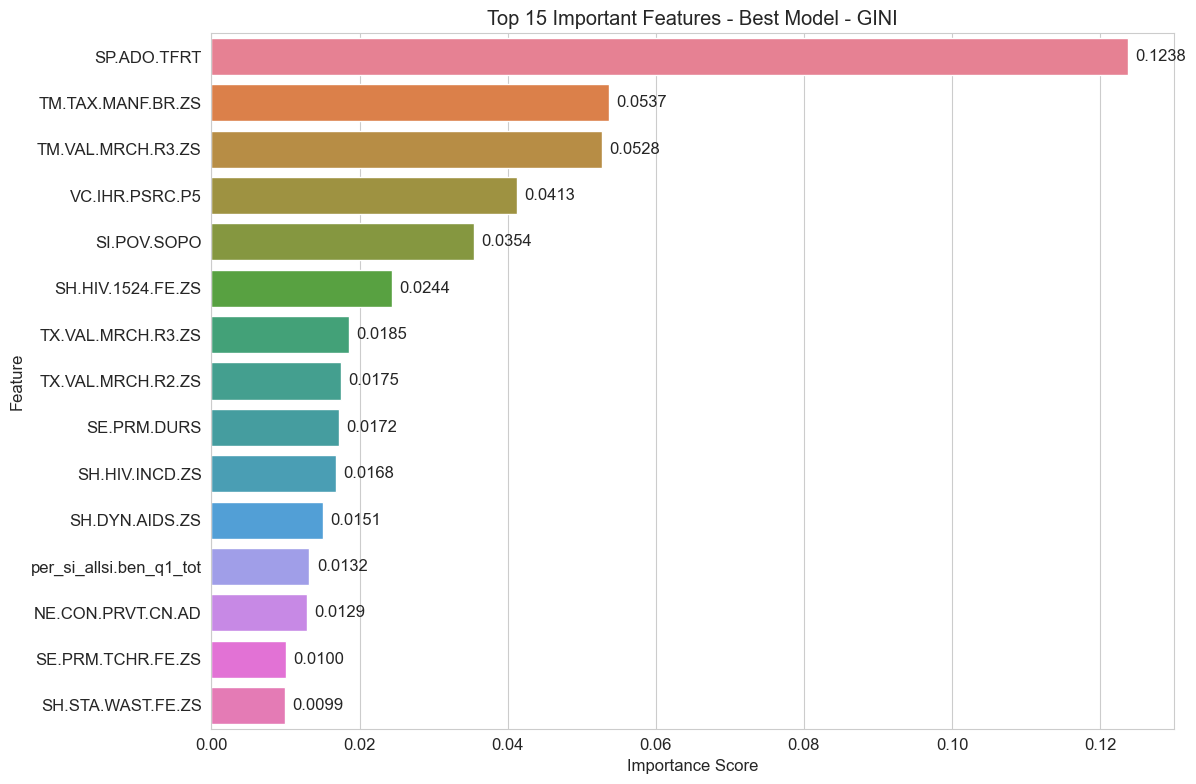

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

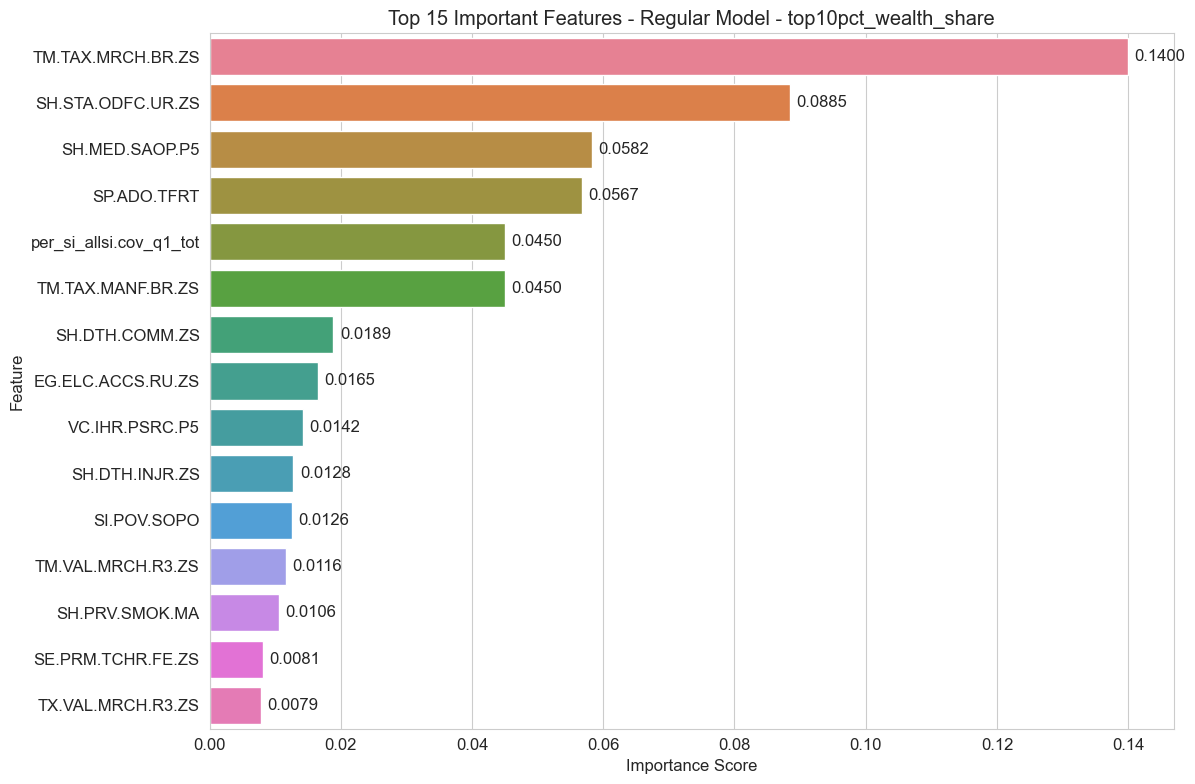

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

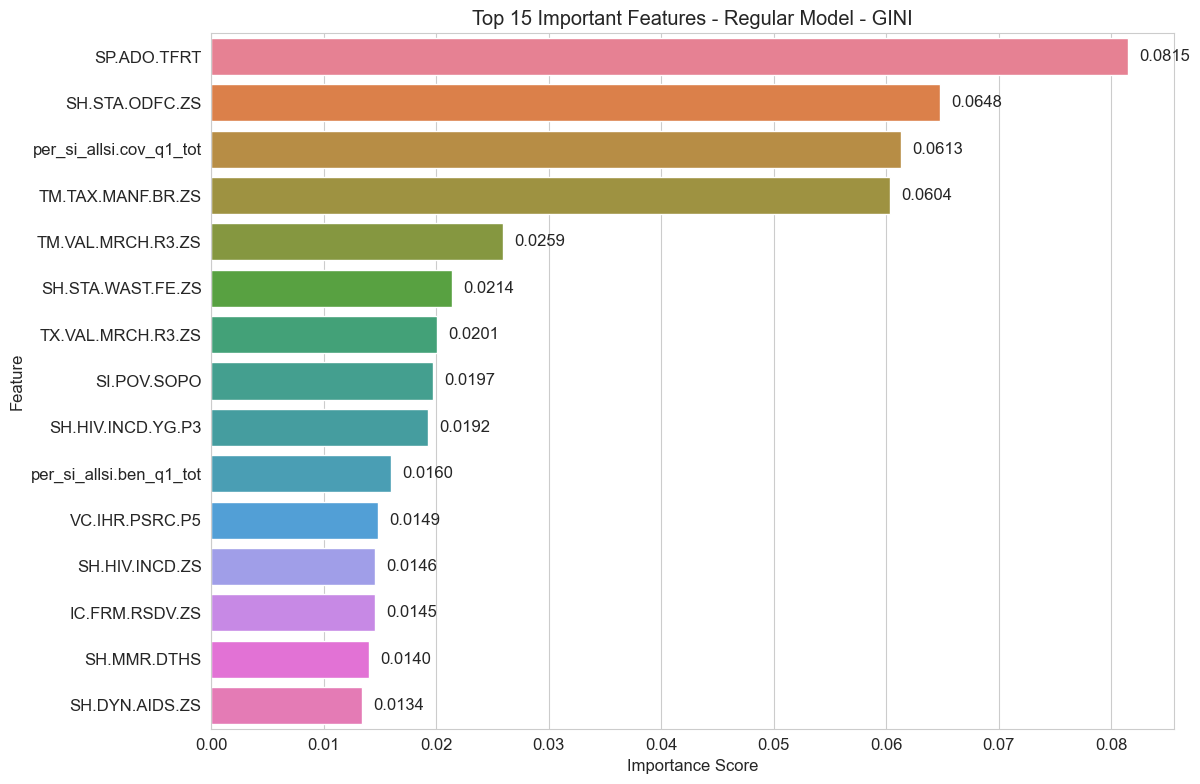

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

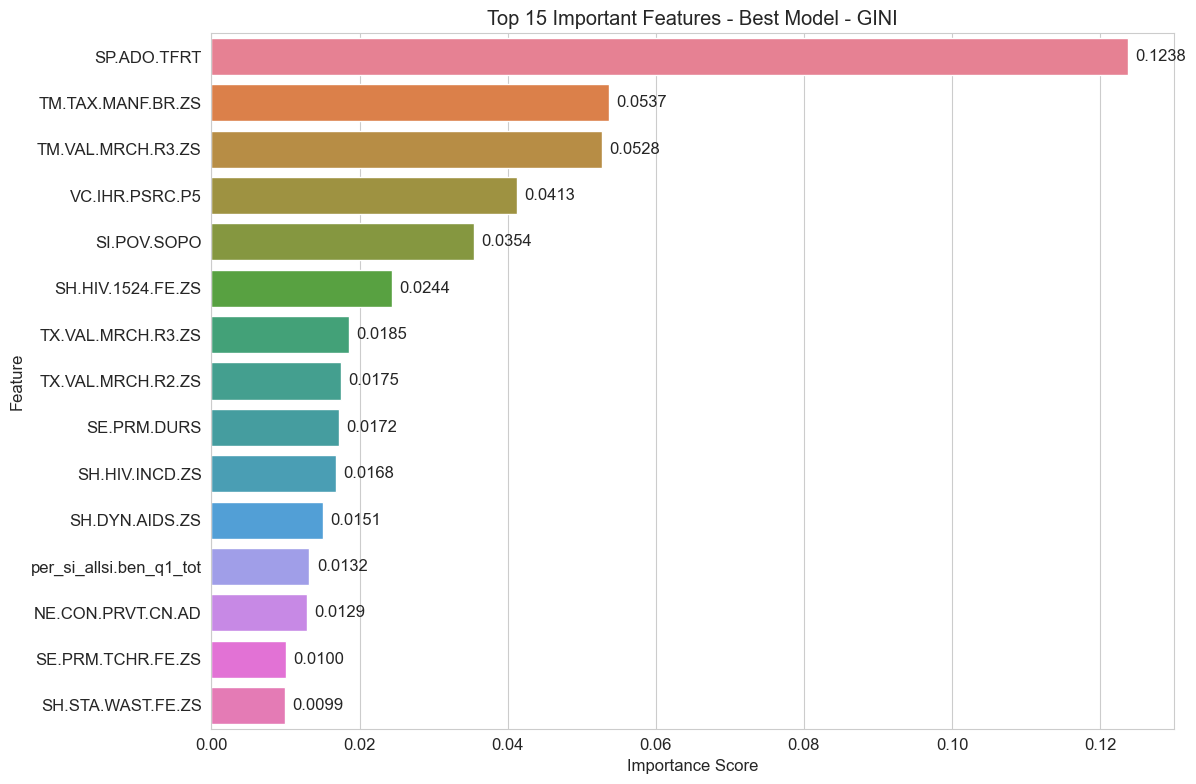

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

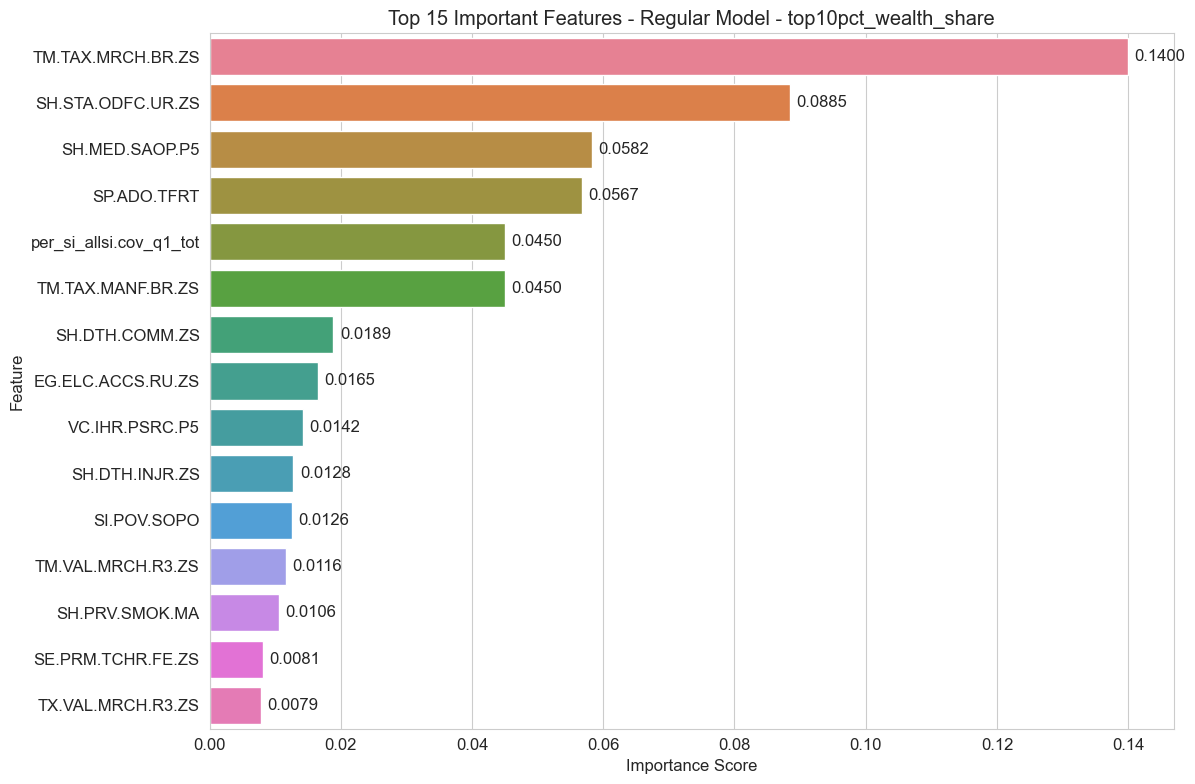

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

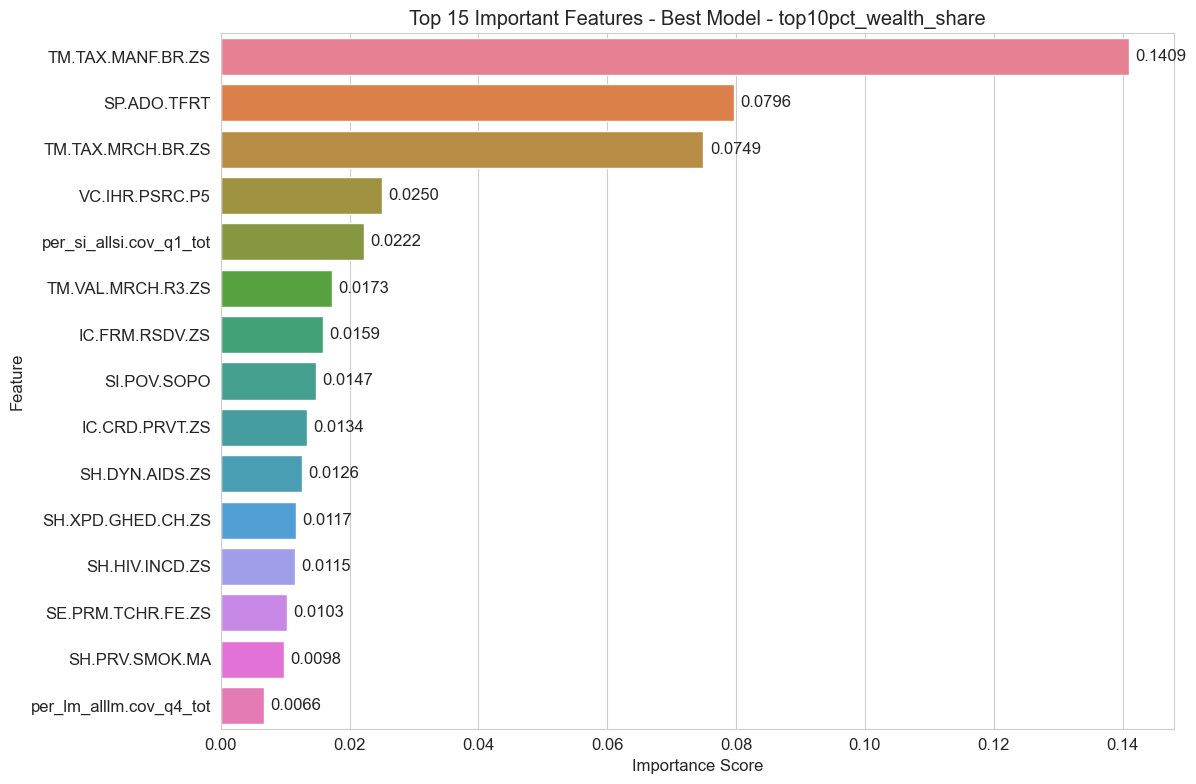

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

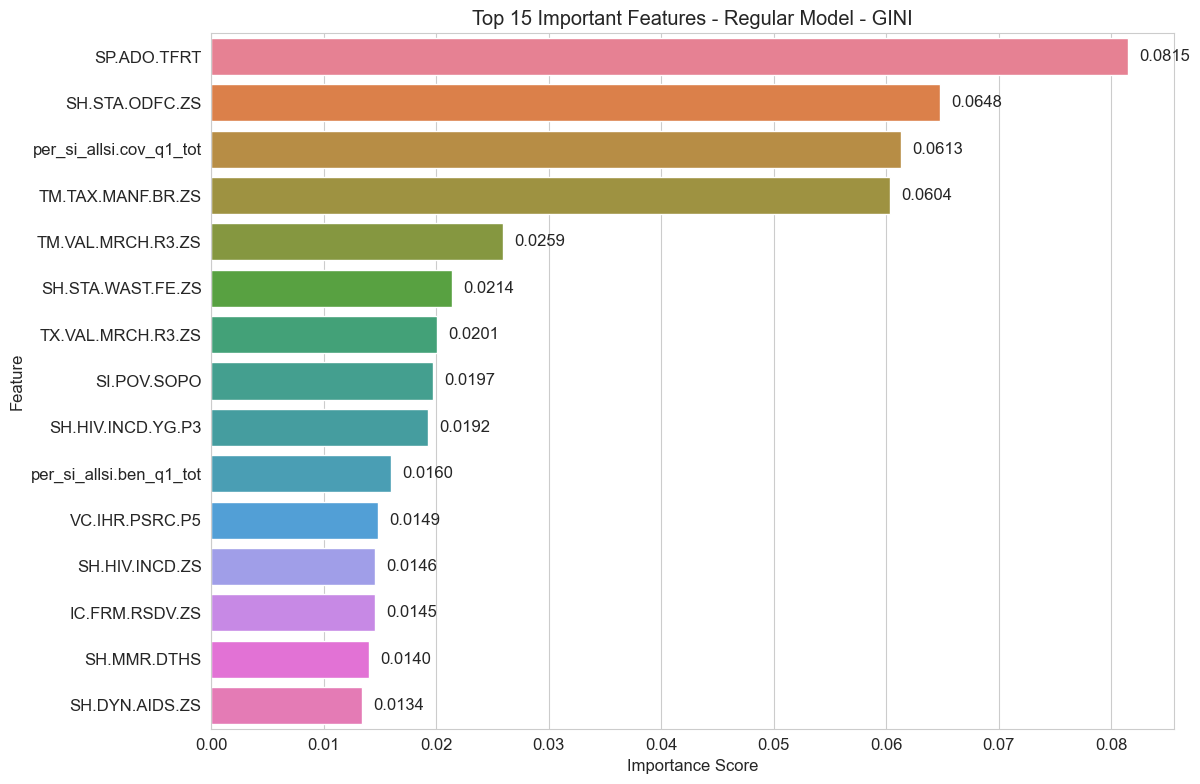

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

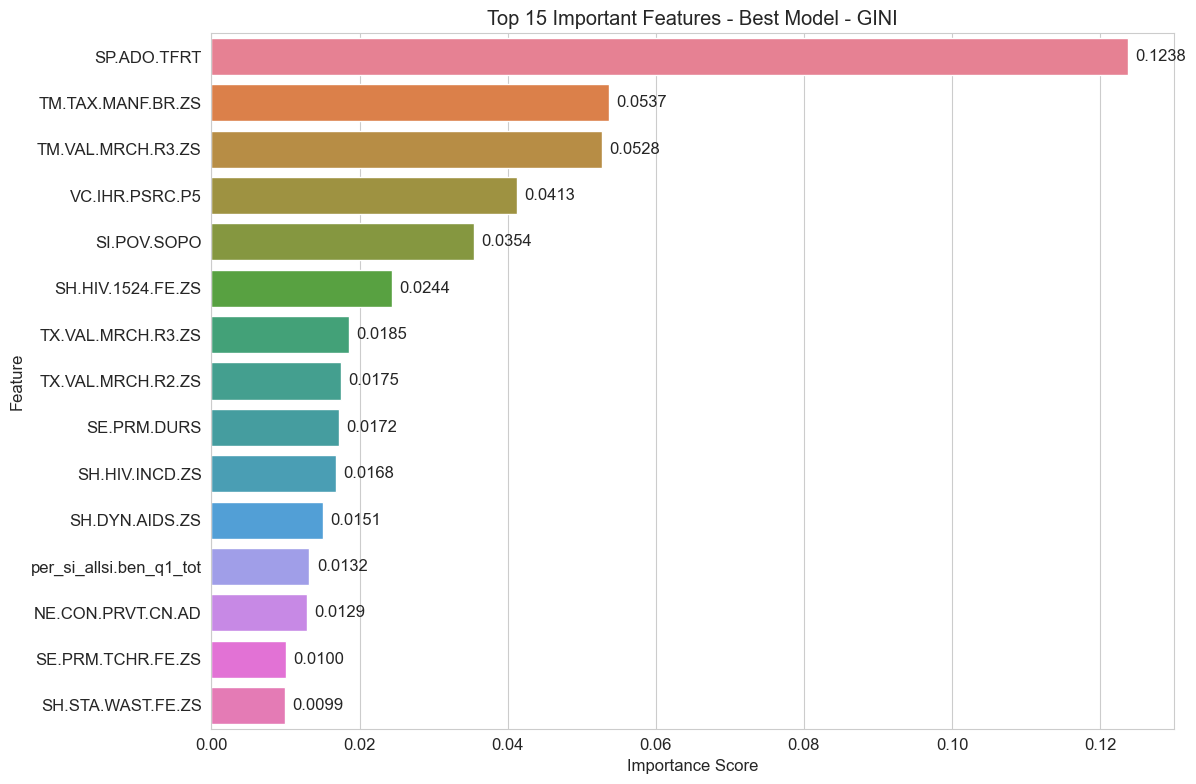

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

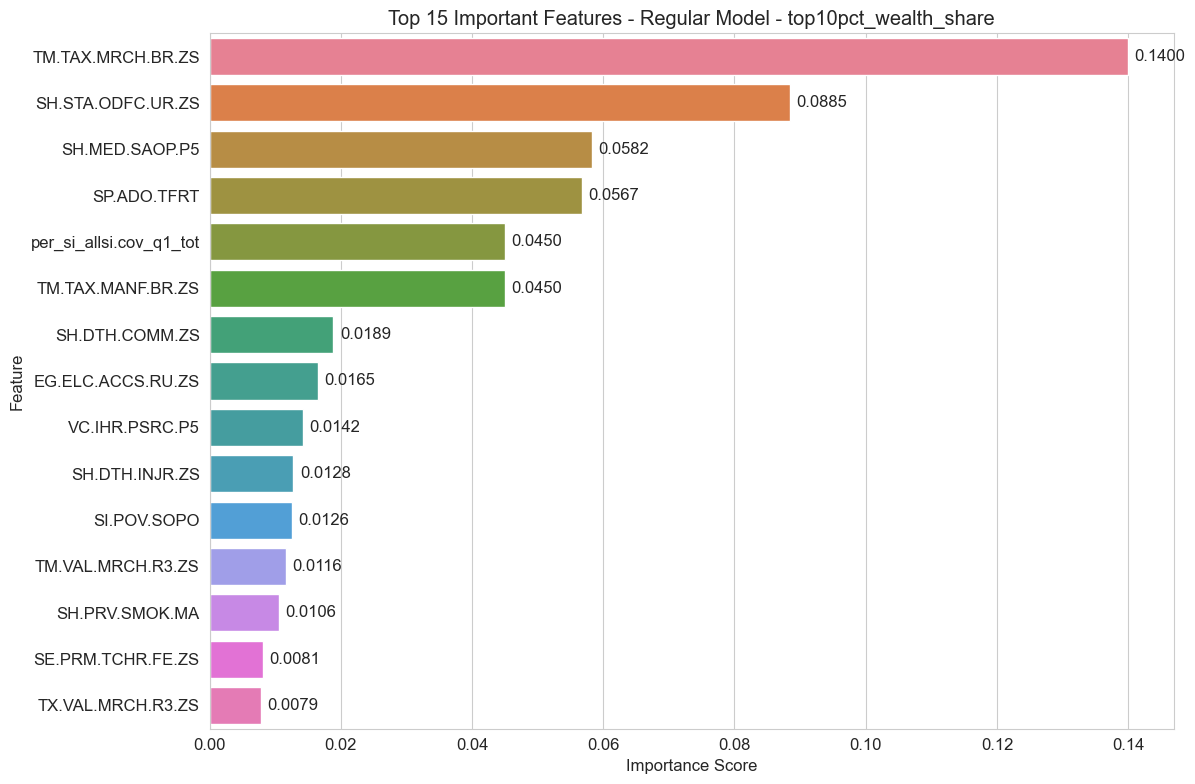

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

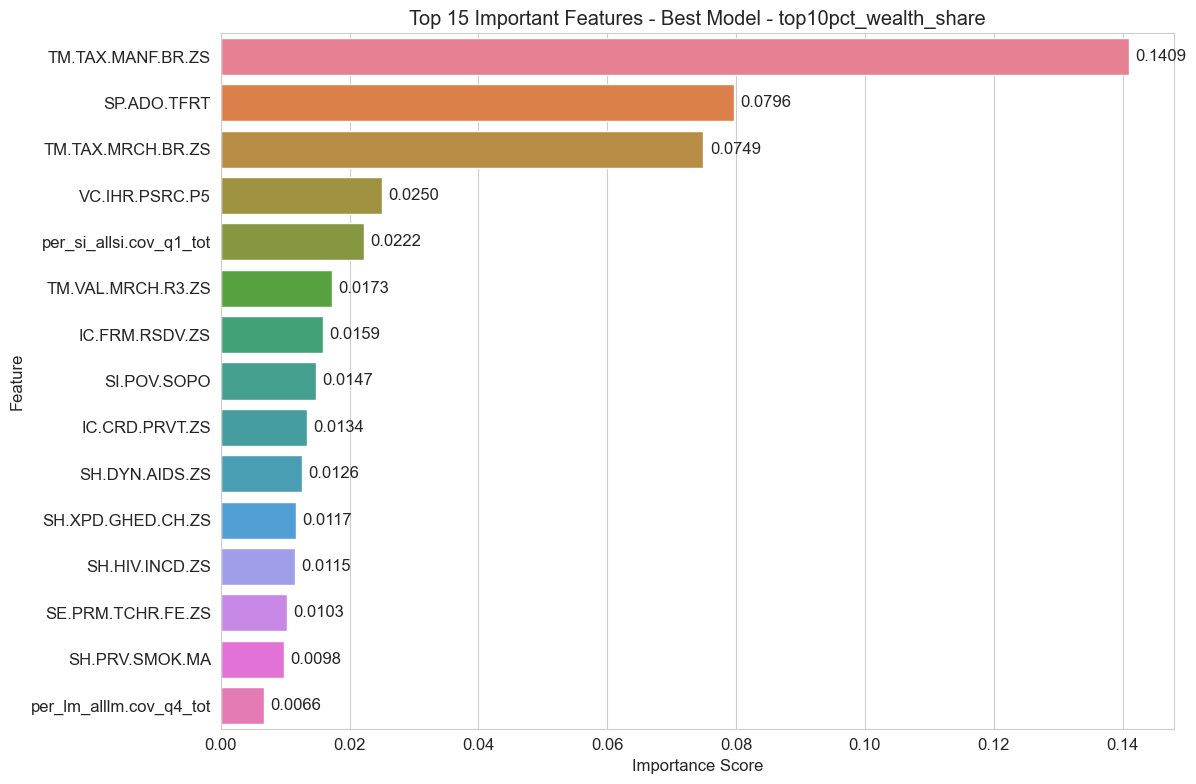

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

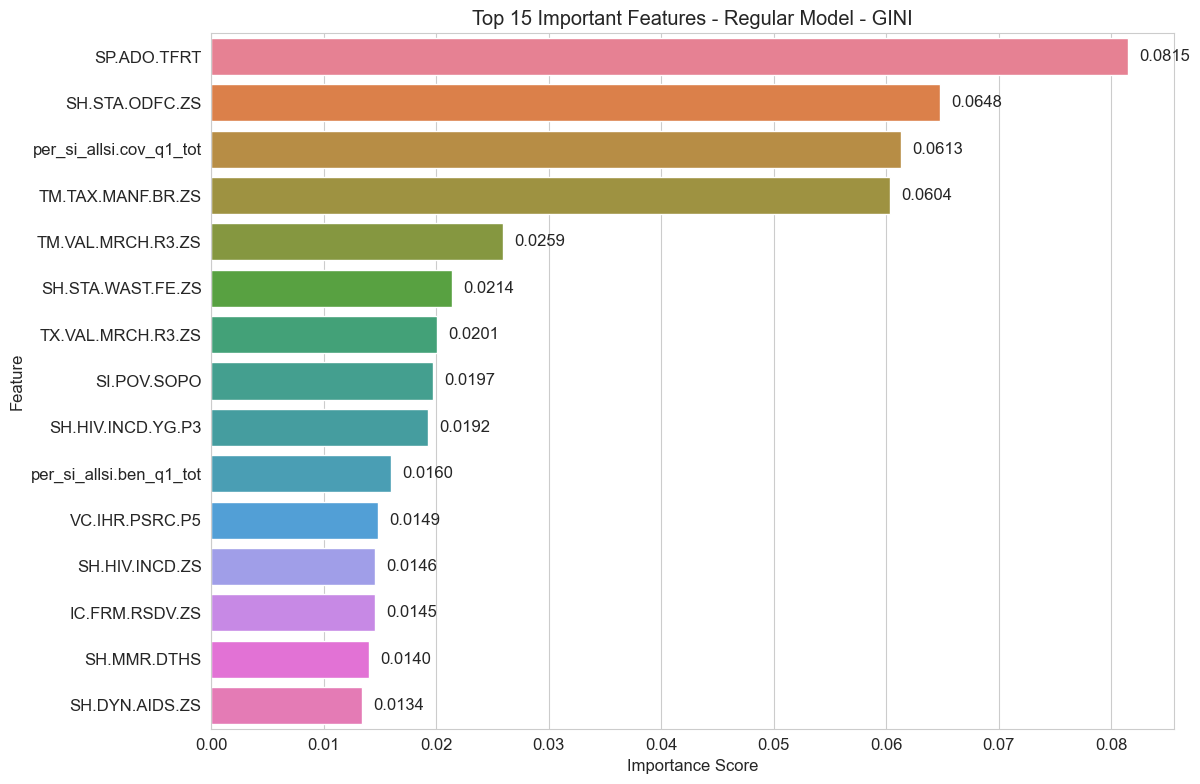

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

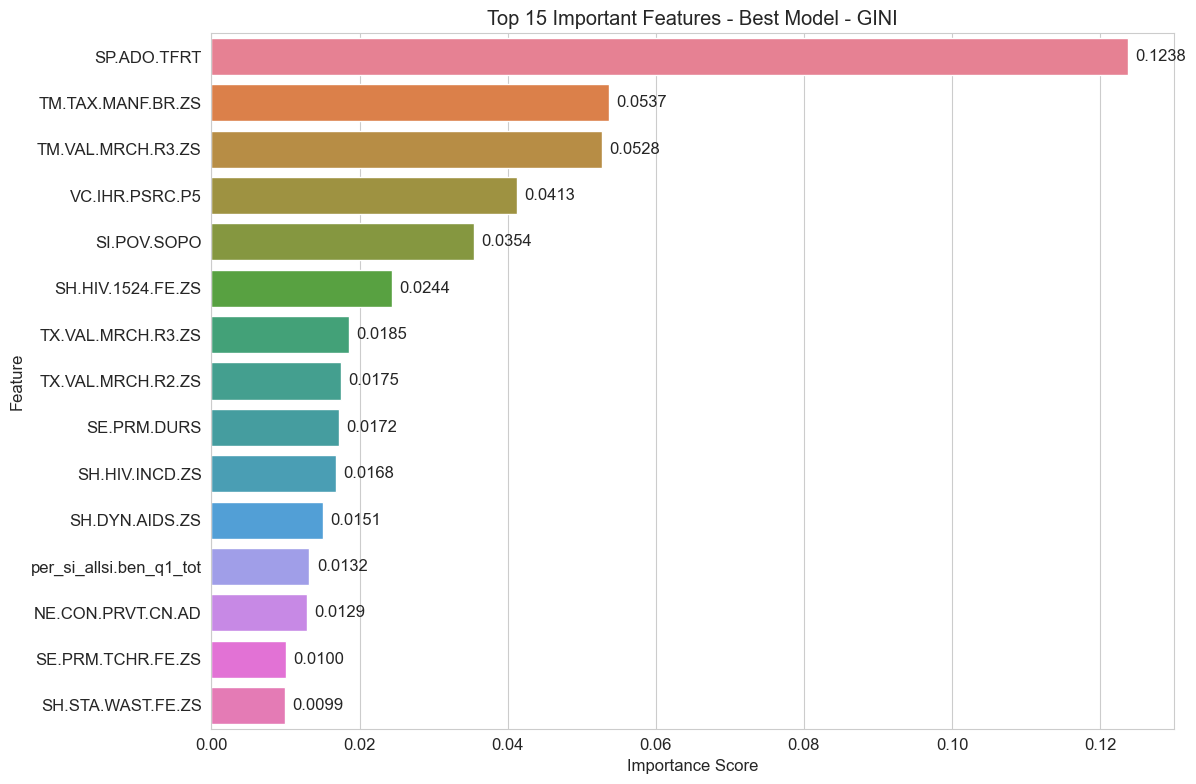

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

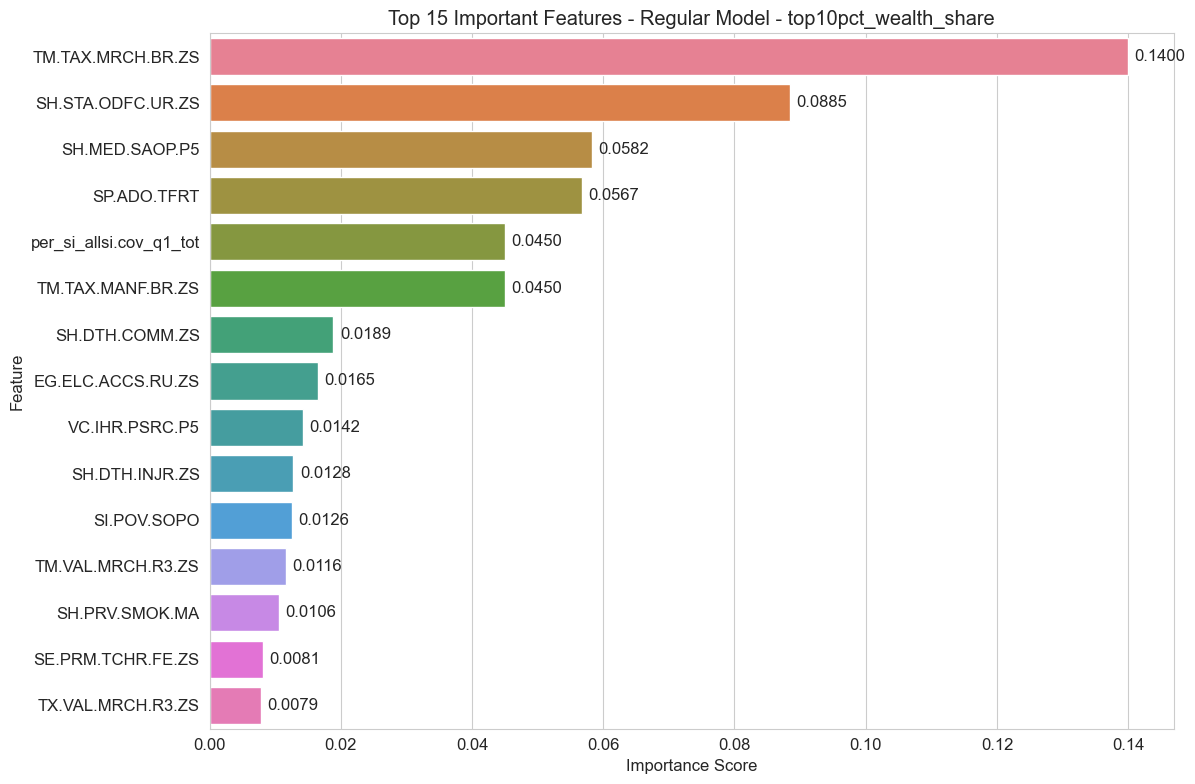

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

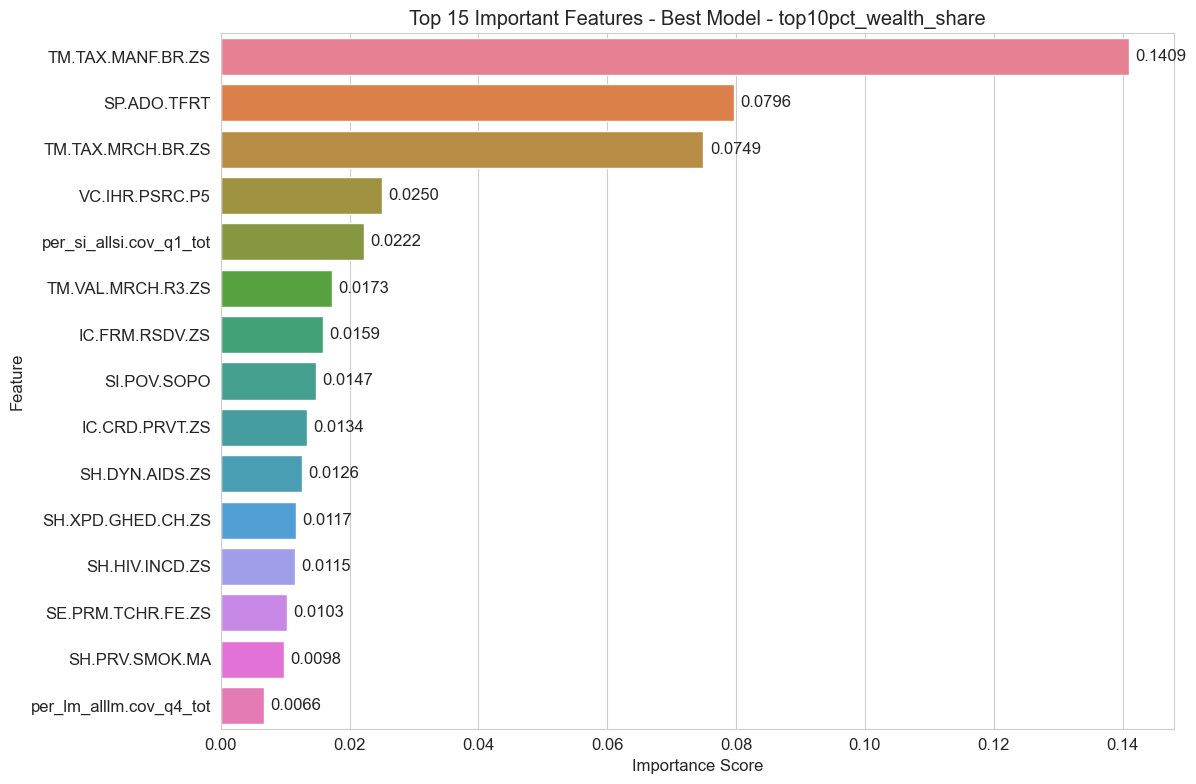

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

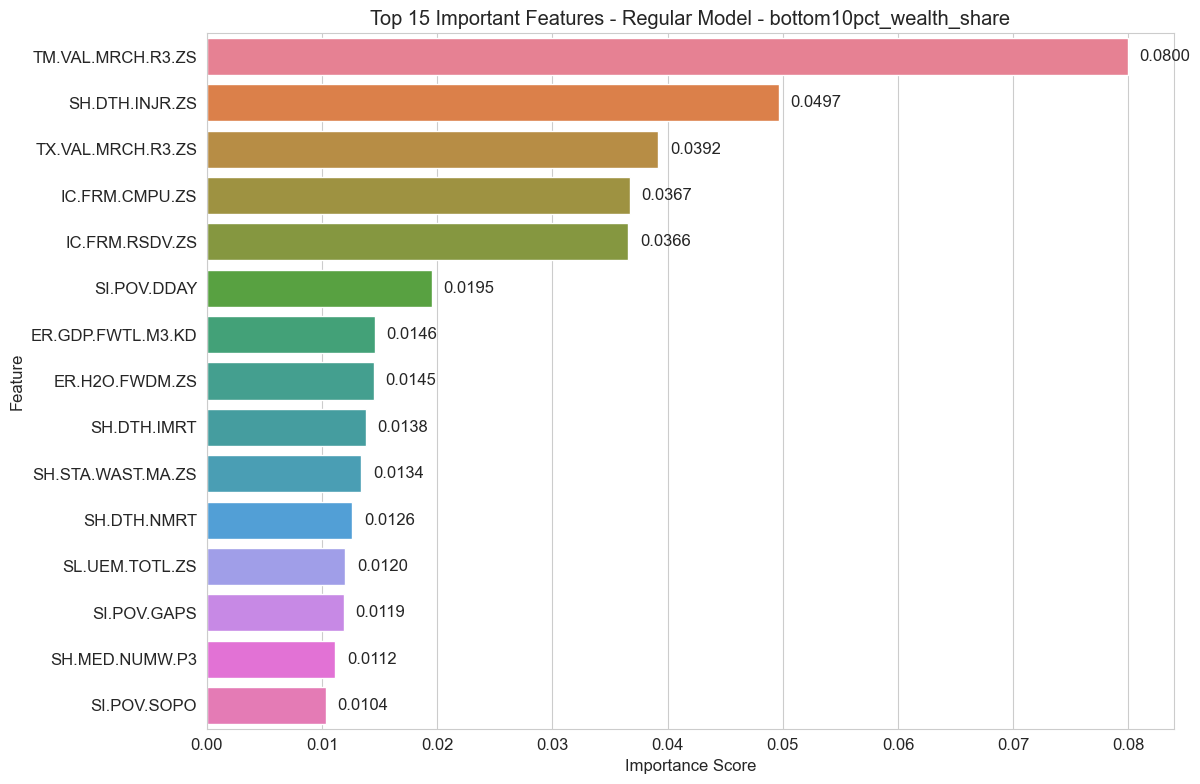

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

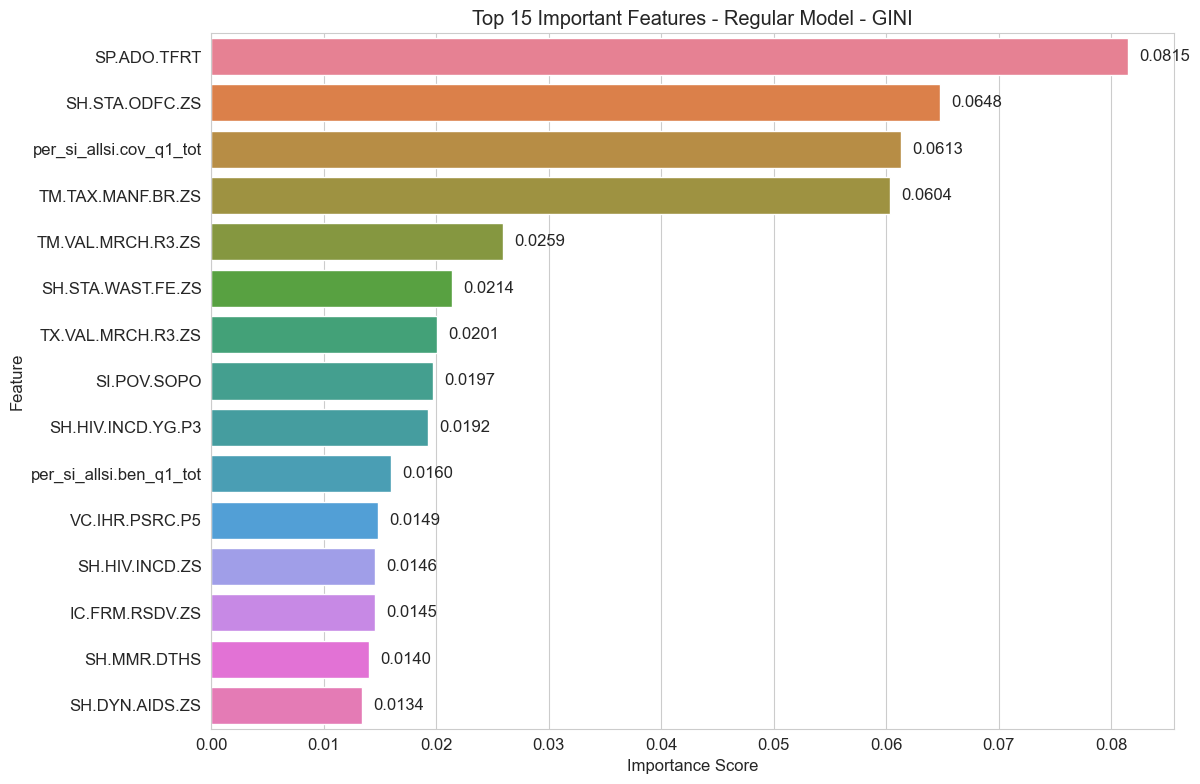

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

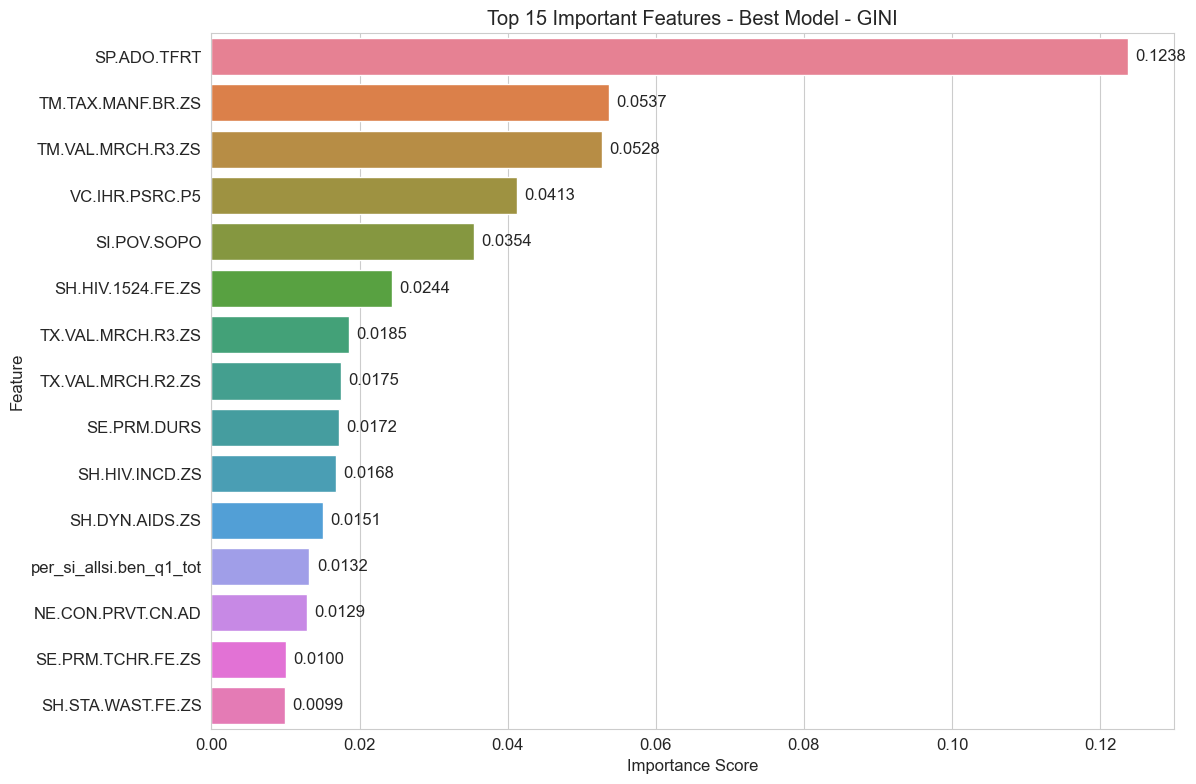

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

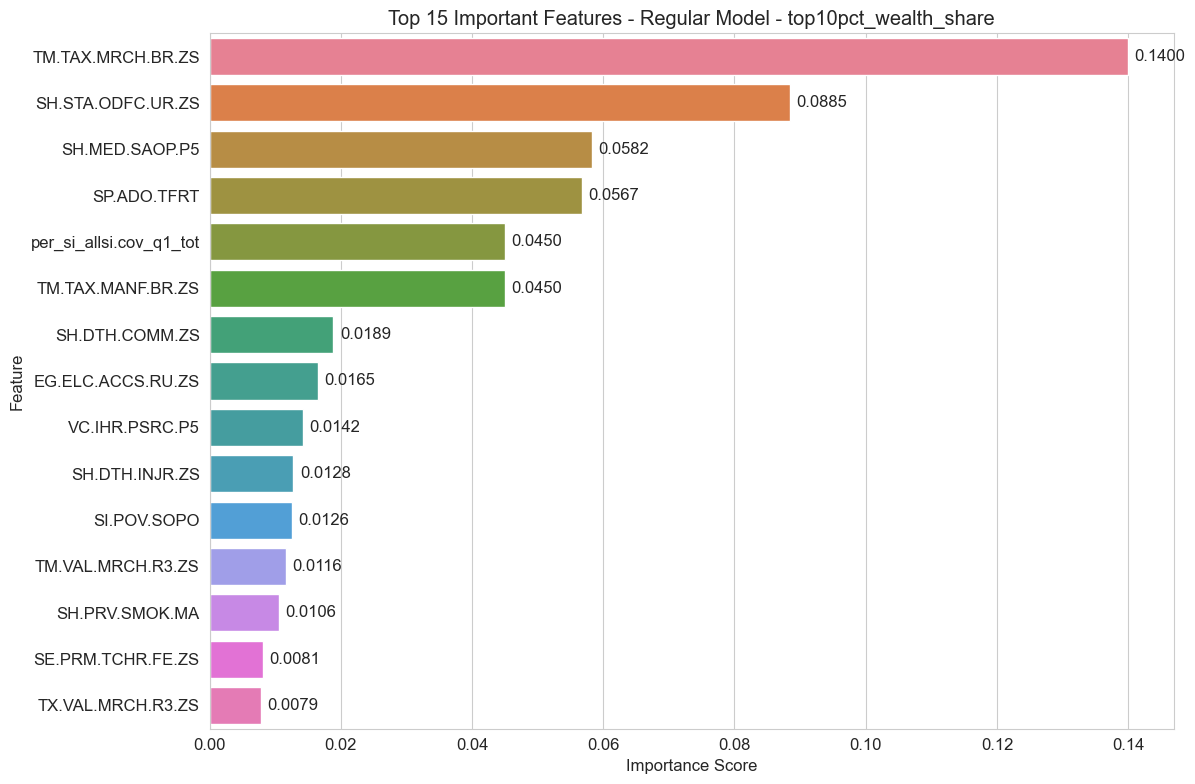

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

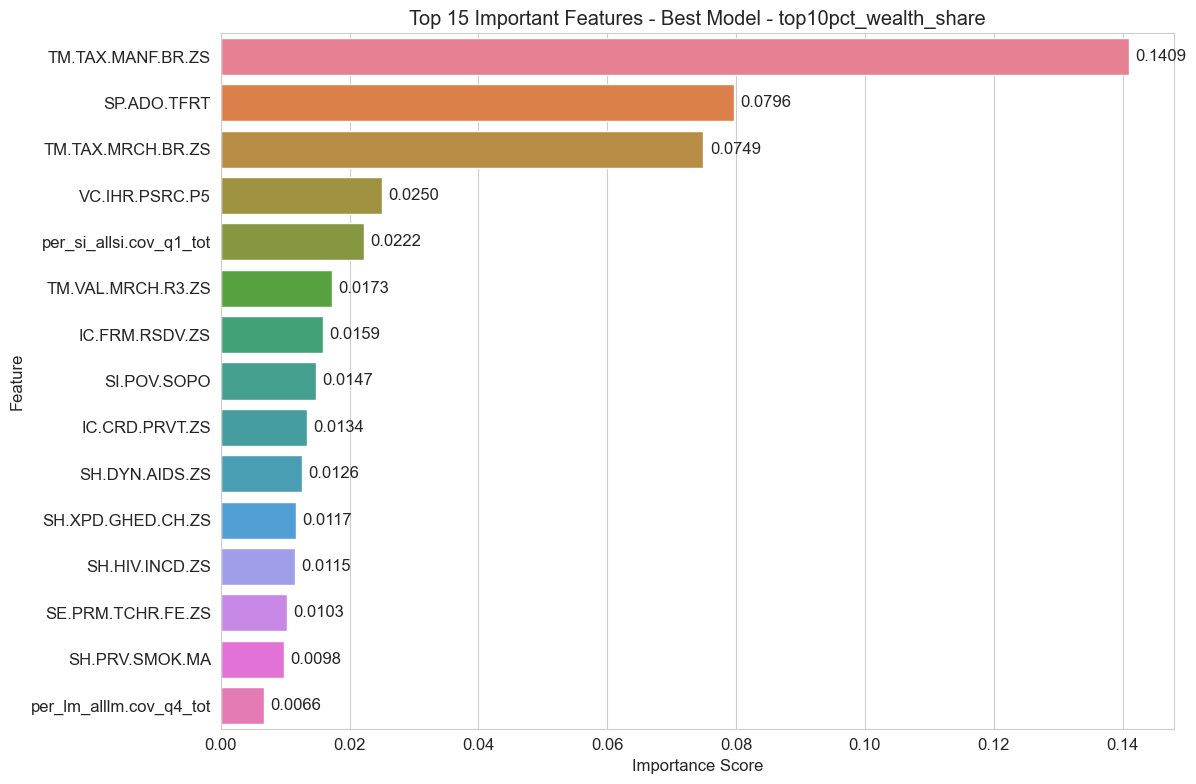

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

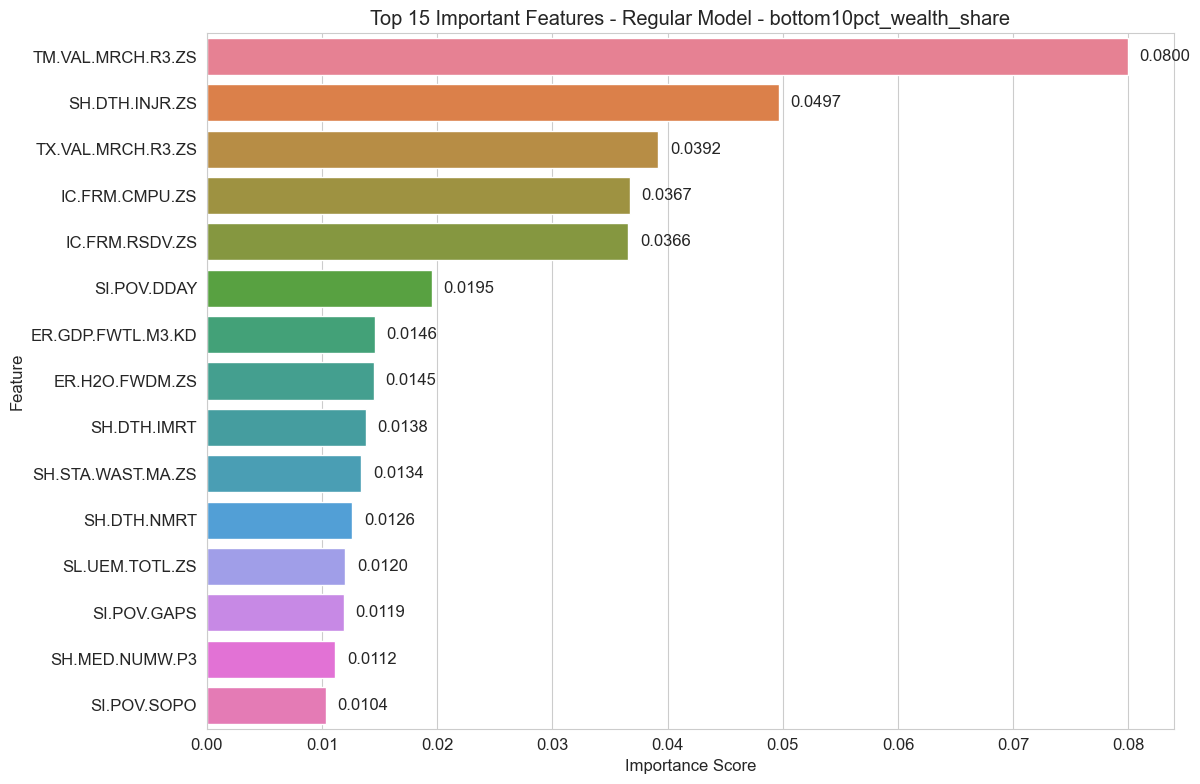

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

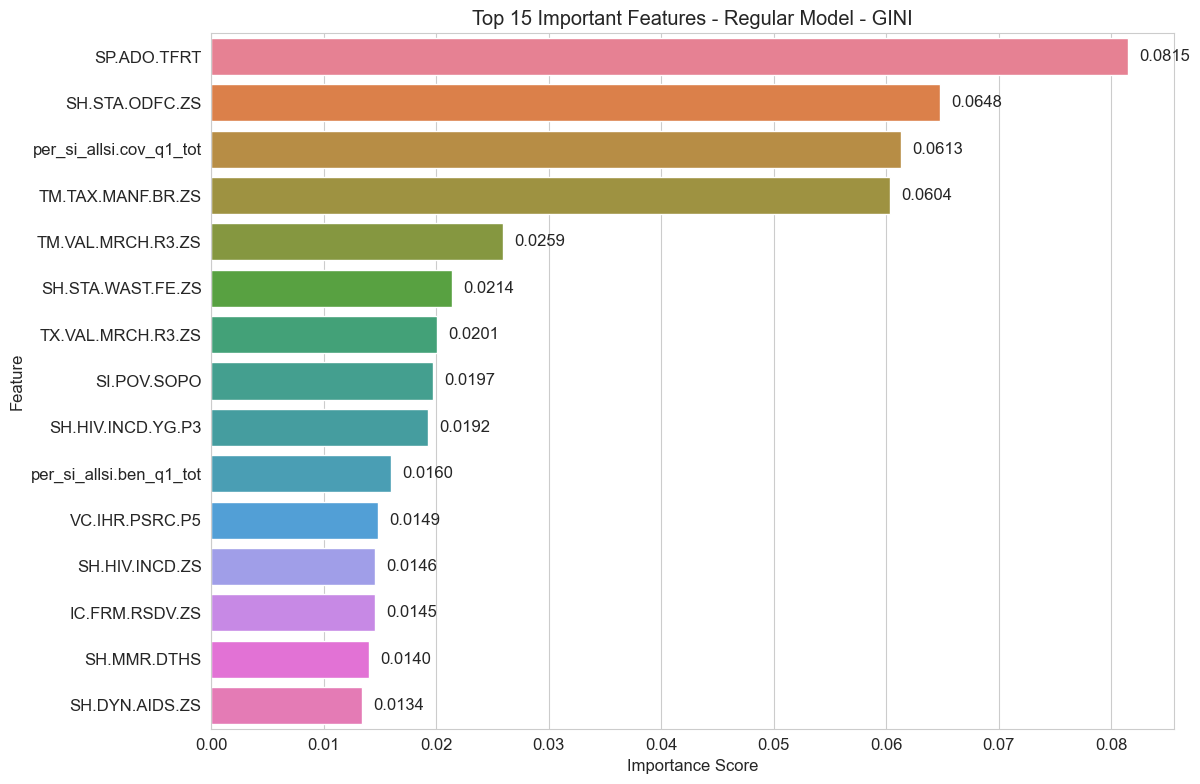

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

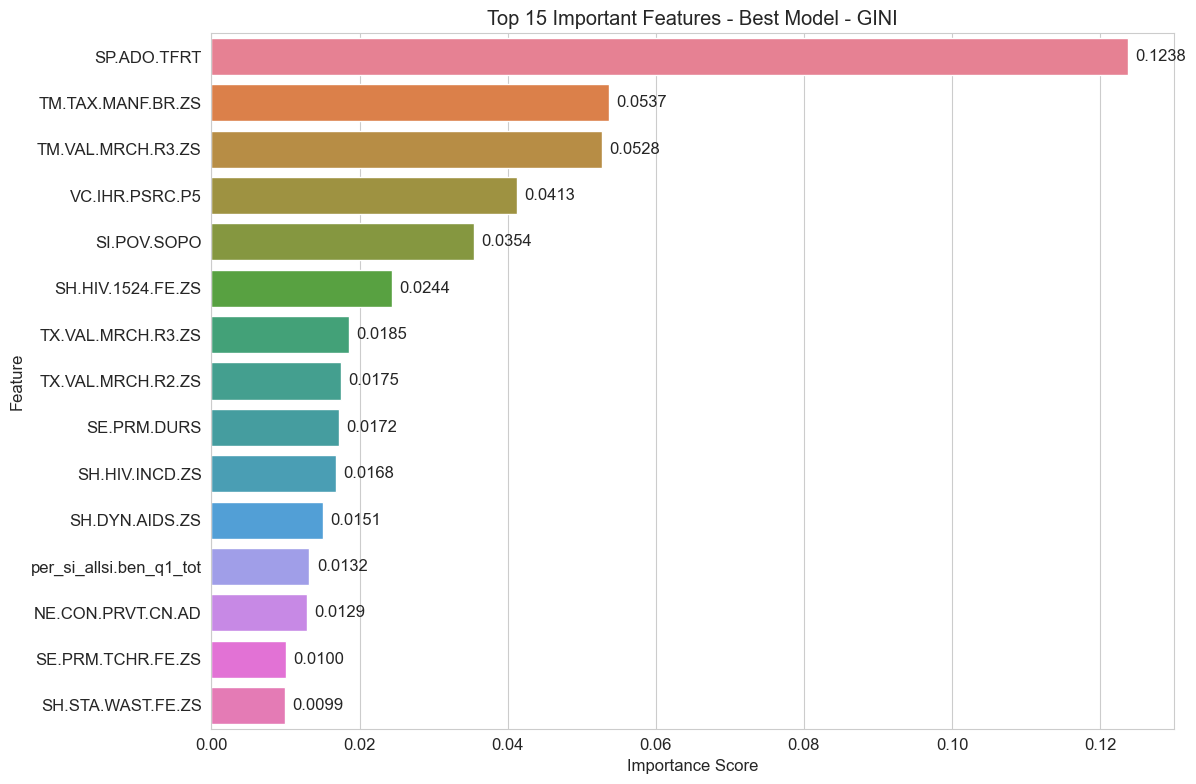

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

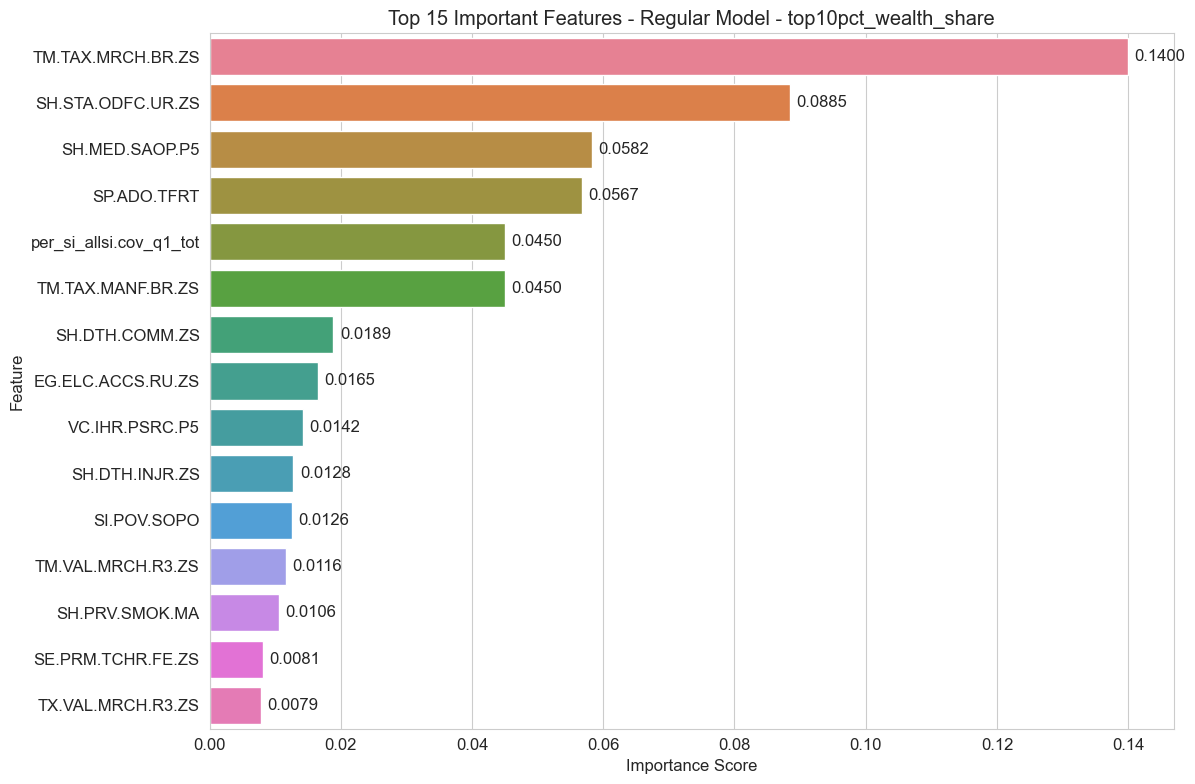

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

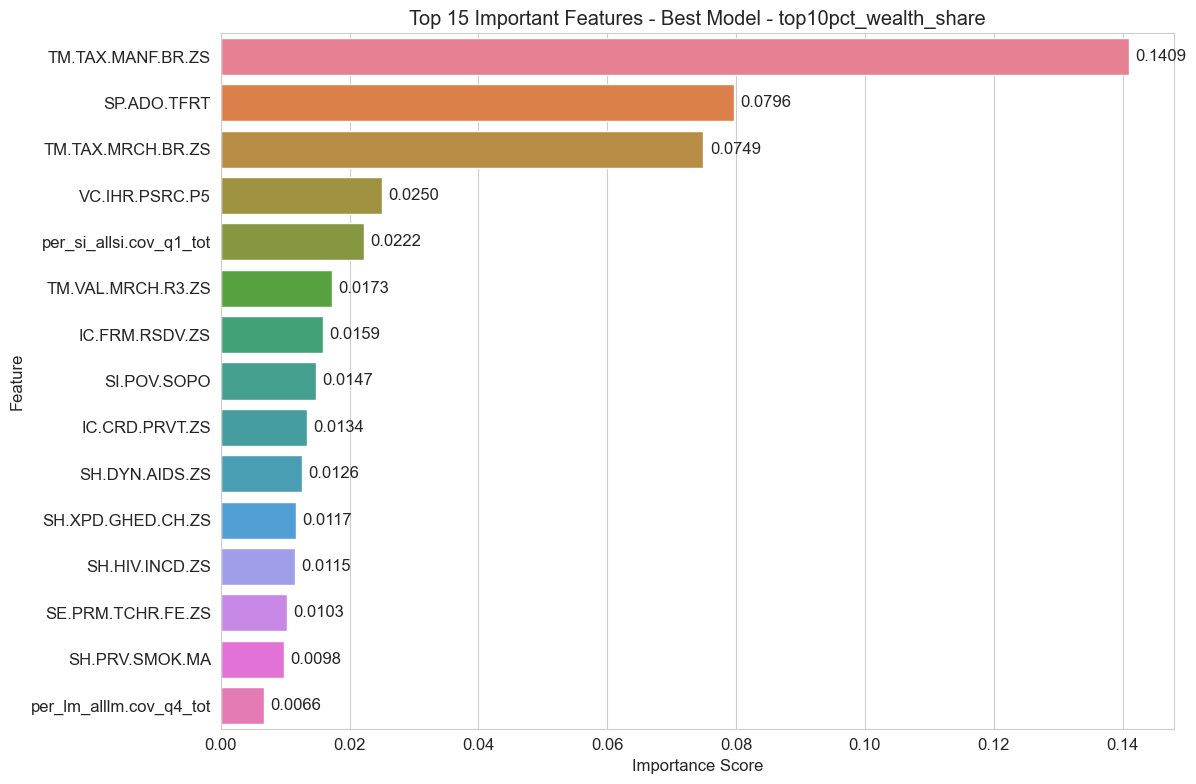

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

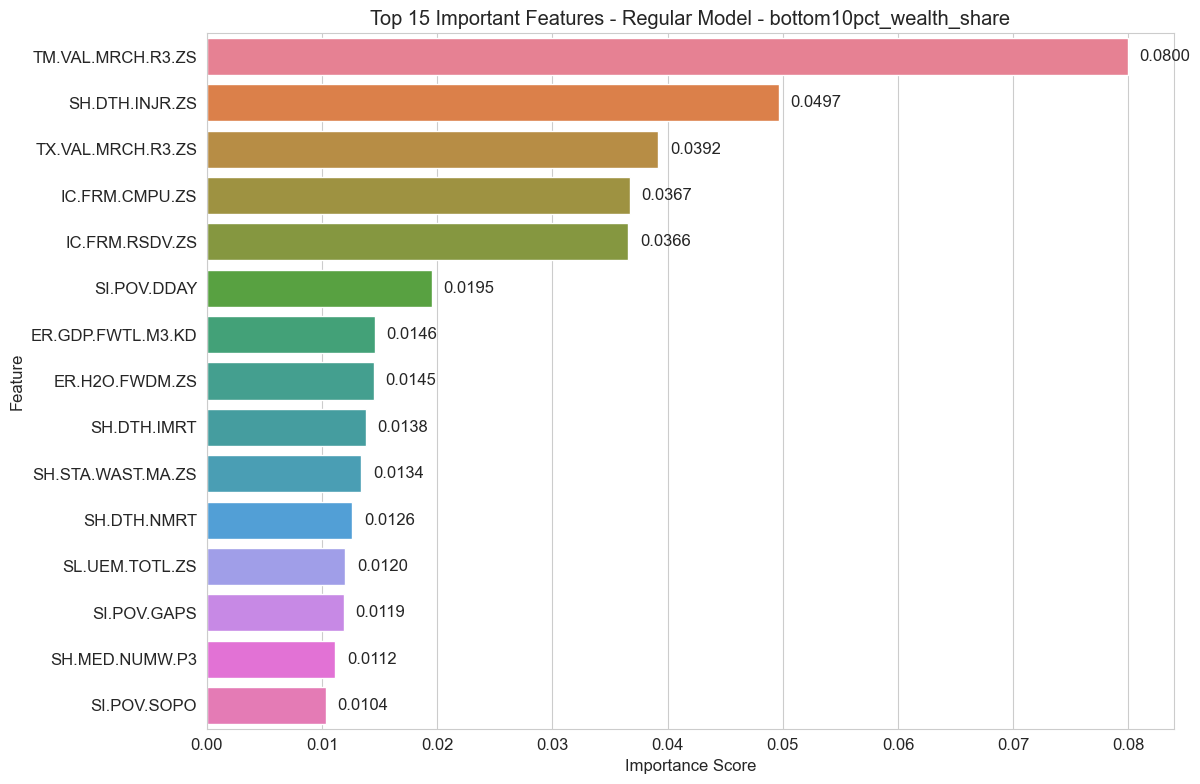

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

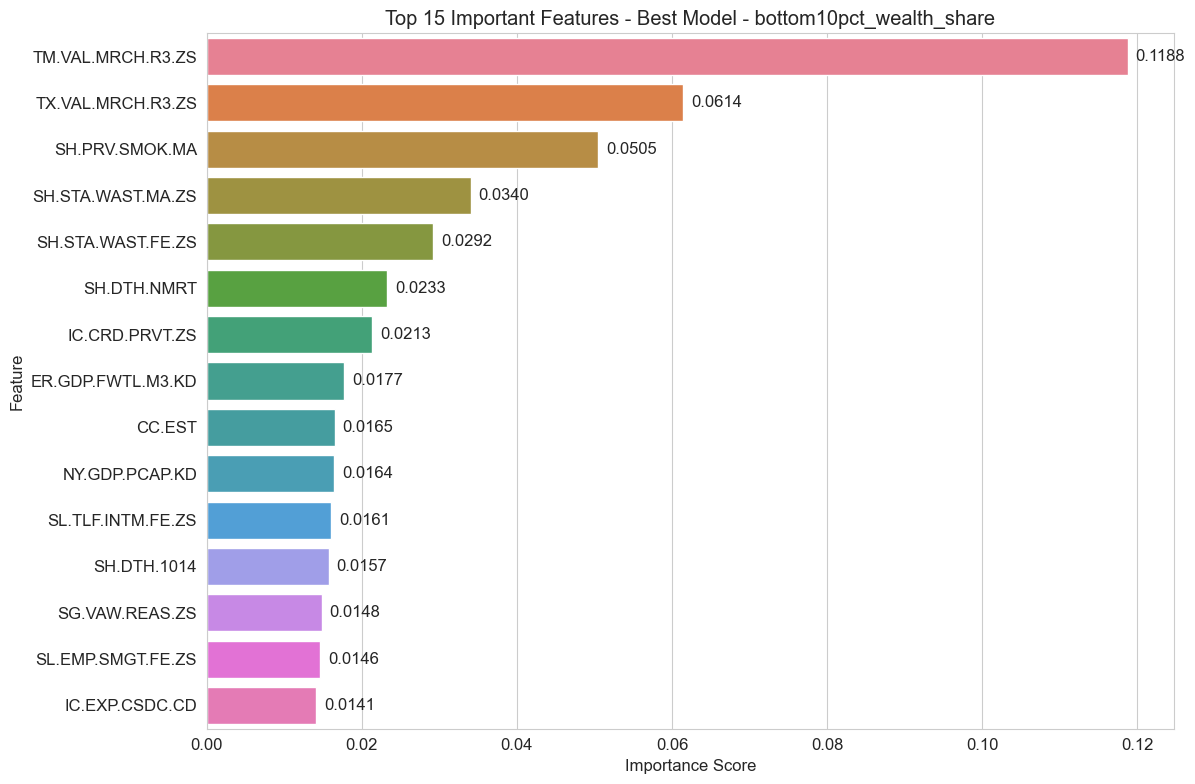

In [37]:
# Load feature importance data
feature_importances = {}
best_feature_importances = {}

for metric in metrics:
    # Handle the different file naming convention
    if metric == 'top10pct_wealth_share':
        file_metric = 'top10pct_wealth_share'
    elif metric == 'bottom10pct_wealth_share':
        file_metric = 'bottom10pct_wealth_share'
    else:
        file_metric = metric
    
    # Load regular feature importances
    try:
        feature_importances[metric] = pd.read_csv(f'output/feature_importance/feature_importances_{file_metric}.csv')
    except Exception as e:
        print(f"Error loading feature importances for {metric}: {e}")
        feature_importances[metric] = pd.DataFrame(columns=['Feature', 'Importance'])
    
    # Load best model feature importances
    try:
        best_feature_importances[metric] = pd.read_csv(f'output/feature_importance/feature_importances_best_{file_metric}.csv')
    except Exception as e:
        print(f"Error loading best feature importances for {metric}: {e}")
        best_feature_importances[metric] = pd.DataFrame(columns=['Feature', 'Importance'])

# Function to plot top N features
def plot_top_features(importance_df, title, top_n=15):
    if importance_df.empty:
        plt.figure(figsize=(10, 2))
        plt.text(0.5, 0.5, "No feature importance data available", 
                 horizontalalignment='center', verticalalignment='center')
        plt.axis('off')
        return plt.gcf()
    
    # Get top N features
    top_features = importance_df.sort_values('Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(12, 8))

    ax = sns.barplot(x=top_features['Importance'], y=top_features['Feature'], palette='viridis', hue=top_features['Feature'], legend=False)
    
    plt.title(title)
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    
    # Add values to the bars
    for i, v in enumerate(top_features['Importance']):
        ax.text(v + 0.001, i, f"{v:.4f}", va='center')
    
    return plt.gcf()

# Plot top features for each metric and model
for metric in metrics:
    # Regular model
    plot_top_features(
        feature_importances[metric],
        f'Top 15 Important Features - Regular Model - {metric}'
    )
    plt.show()
    
    # Best model
    plot_top_features(
        best_feature_importances[metric],
        f'Top 15 Important Features - Best Model - {metric}'
    )
    plt.show()

## Error Distribution Analysis

Let's analyze how errors are distributed across the prediction range.

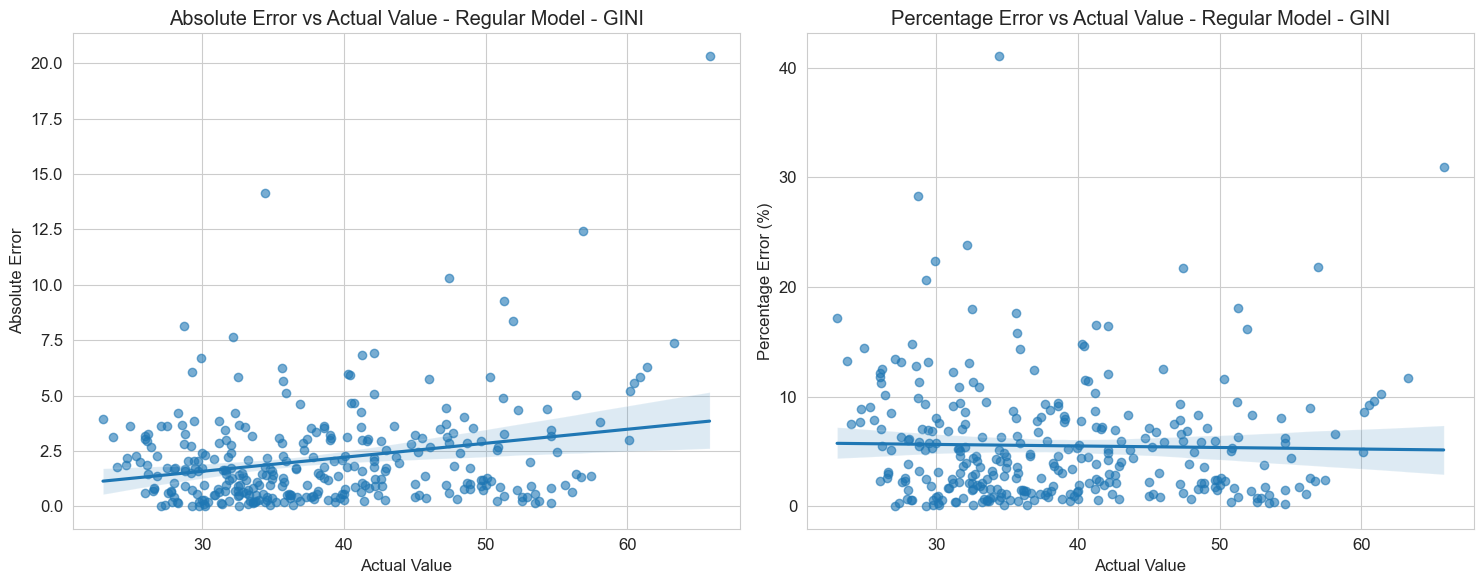

=== Error Summary for Regular Model - GINI ===

Absolute Error Statistics:
count    317.000000
mean       2.112406
std        2.249870
min        0.003556
25%        0.618056
50%        1.498225
75%        2.988072
max       20.337270
Name: Absolute Error, dtype: float64

Percentage Error Statistics:
count    317.000000
mean       5.526837
std        5.390713
min        0.012137
25%        1.593550
50%        4.118557
75%        7.745515
max       41.068372
Name: Percentage Error, dtype: float64

--------------------------------------------------



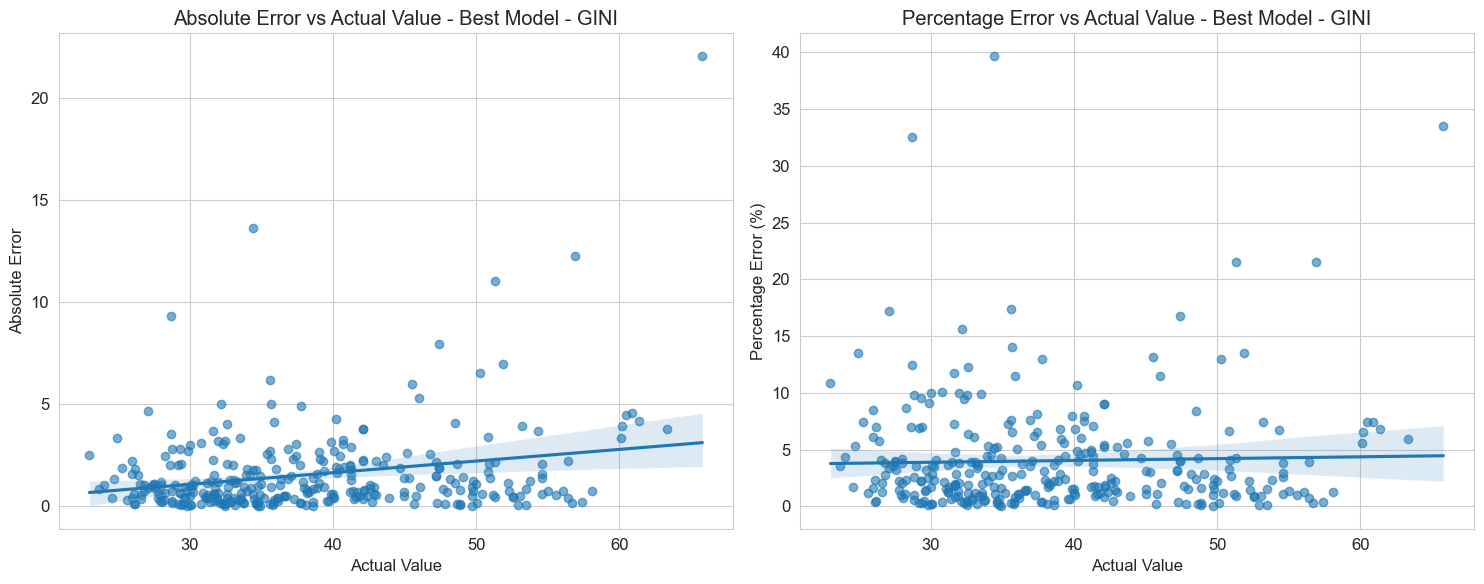

=== Error Summary for Best Model - GINI ===

Absolute Error Statistics:
count    317.000000
mean       1.555443
std        2.105210
min        0.002415
25%        0.418360
50%        0.945052
75%        2.009907
max       22.074902
Name: Absolute Error, dtype: float64

Percentage Error Statistics:
count    317.000000
mean       4.013426
std        4.798989
min        0.004859
25%        1.145085
50%        2.579267
75%        5.192116
max       39.700535
Name: Percentage Error, dtype: float64

--------------------------------------------------



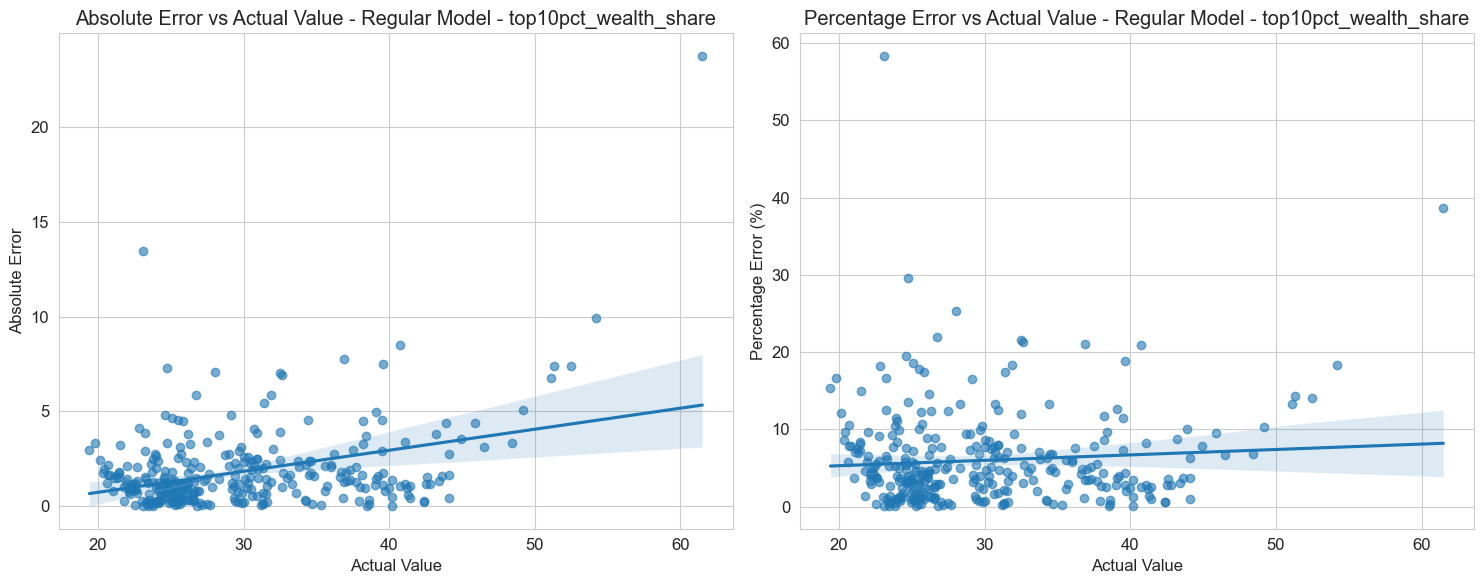

=== Error Summary for Regular Model - top10pct_wealth_share ===

Absolute Error Statistics:
count    317.000000
mean       1.823562
std        2.164130
min        0.011914
25%        0.660780
50%        1.257077
75%        2.278642
max       23.771217
Name: Absolute Error, dtype: float64

Percentage Error Statistics:
count    317.000000
mean       5.980095
std        6.107905
min        0.044455
25%        2.283350
50%        4.502309
75%        7.727919
max       58.361195
Name: Percentage Error, dtype: float64

--------------------------------------------------



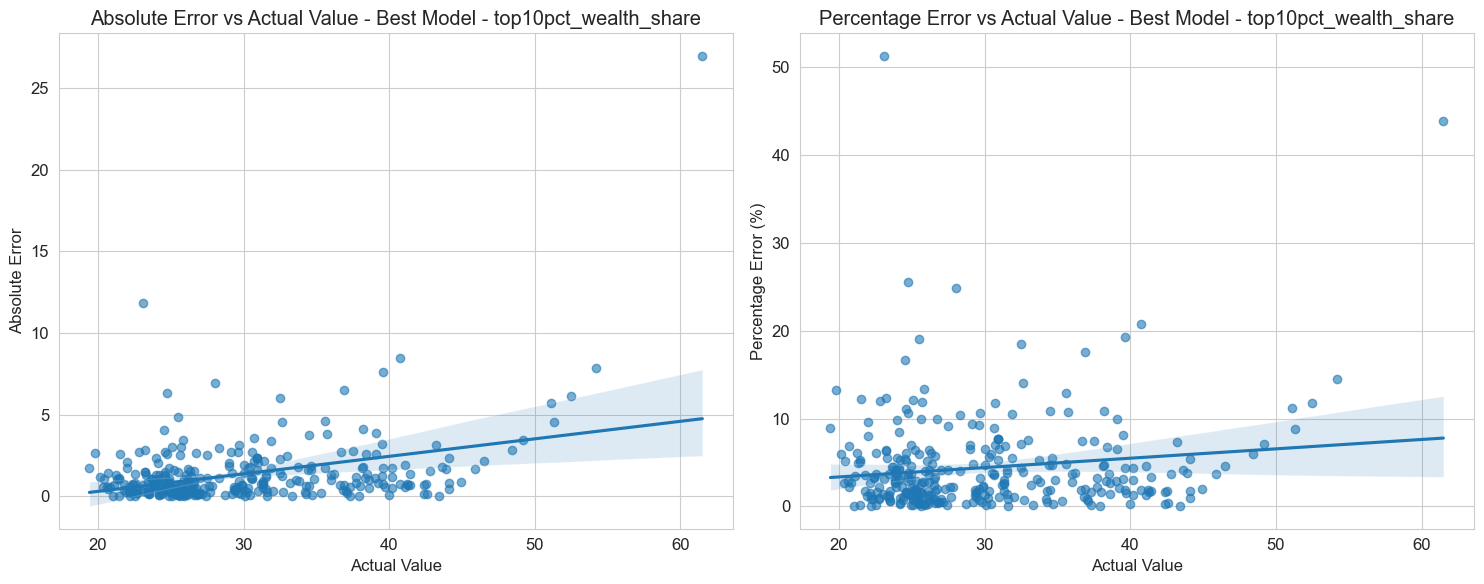

=== Error Summary for Best Model - top10pct_wealth_share ===

Absolute Error Statistics:
count    317.000000
mean       1.373638
std        2.080232
min        0.006224
25%        0.367841
50%        0.801880
75%        1.674603
max       26.959950
Name: Absolute Error, dtype: float64

Percentage Error Statistics:
count    317.000000
mean       4.410629
std        5.392741
min        0.028036
25%        1.336090
50%        2.935431
75%        5.528721
max       51.255472
Name: Percentage Error, dtype: float64

--------------------------------------------------



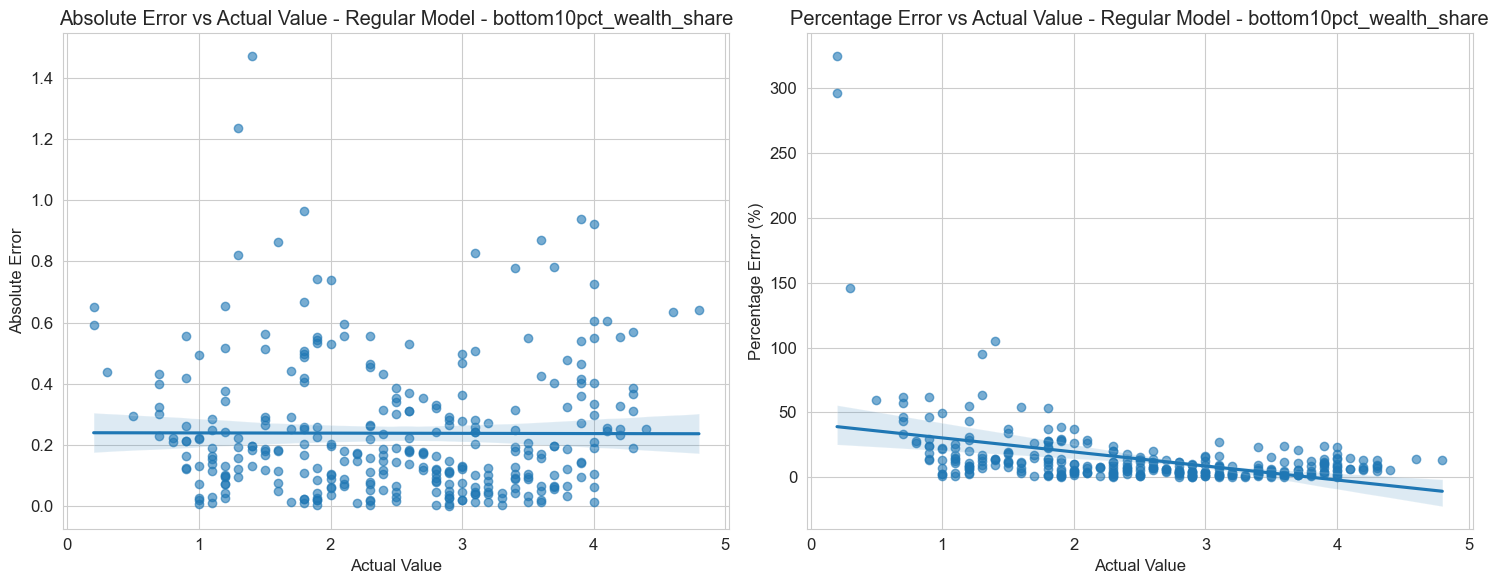

=== Error Summary for Regular Model - bottom10pct_wealth_share ===

Absolute Error Statistics:
count    317.000000
mean       0.238397
std        0.220278
min        0.000051
25%        0.081560
50%        0.179712
75%        0.319914
max        1.471144
Name: Absolute Error, dtype: float64

Percentage Error Statistics:
count    317.000000
mean      14.074680
std       28.515836
min        0.001759
25%        3.116506
50%        7.477700
75%       14.202832
max      325.012200
Name: Percentage Error, dtype: float64

--------------------------------------------------



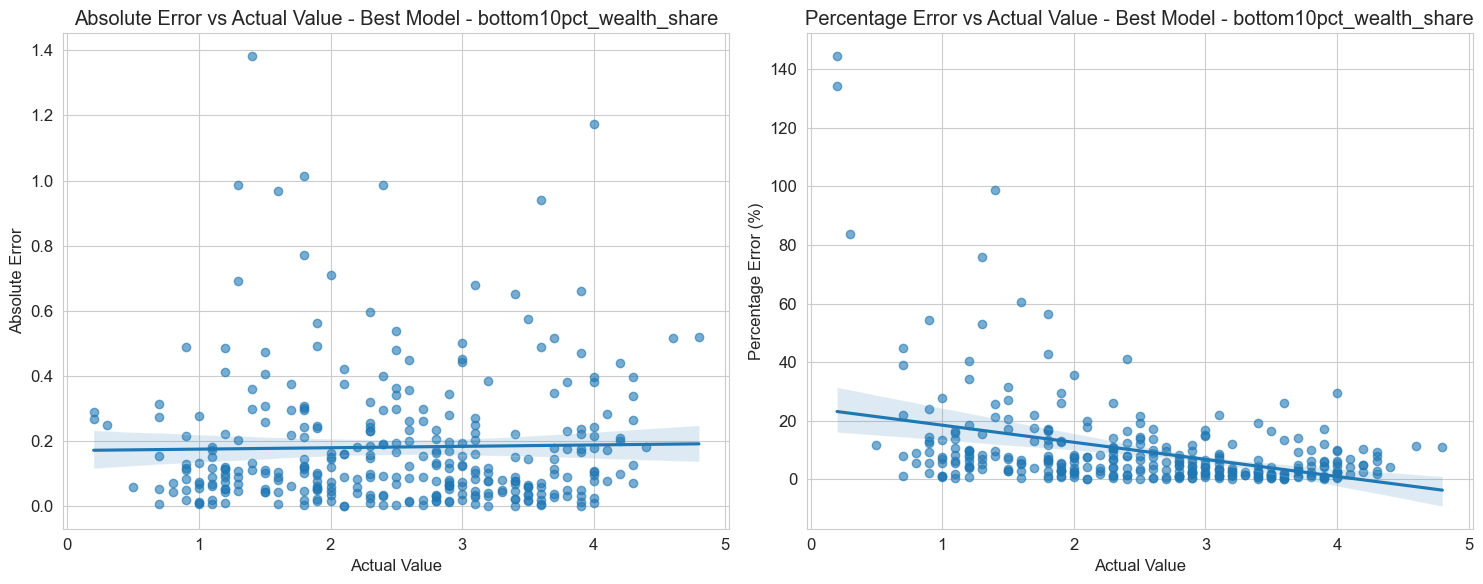

=== Error Summary for Best Model - bottom10pct_wealth_share ===

Absolute Error Statistics:
count    317.000000
mean       0.181994
std        0.203419
min        0.000402
25%        0.051713
50%        0.112752
75%        0.240722
max        1.382847
Name: Absolute Error, dtype: float64

Percentage Error Statistics:
count    317.000000
mean       9.728746
std       16.071041
min        0.012572
25%        2.112033
50%        5.409628
75%       10.527252
max      144.605125
Name: Percentage Error, dtype: float64

--------------------------------------------------



In [35]:
# Function to create error analysis plots
def analyze_error_distribution(actual, predicted, title):
    # Calculate absolute and percentage errors
    abs_error = np.abs(actual - predicted)
    pct_error = (abs_error / actual) * 100
    
    # Create dataframe for analysis
    error_df = pd.DataFrame({
        'Actual': actual,
        'Predicted': predicted,
        'Absolute Error': abs_error,
        'Percentage Error': pct_error
    })
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Absolute error vs actual value
    # Use scatter directly to avoid grouping warning
    ax1.scatter(error_df['Actual'], error_df['Absolute Error'], alpha=0.6)
    # Add a regression line manually
    sns.regplot(x='Actual', y='Absolute Error', data=error_df, ax=ax1, scatter=False)
    ax1.set_xlabel('Actual Value')
    ax1.set_ylabel('Absolute Error')
    ax1.set_title(f'Absolute Error vs Actual Value - {title}')
    ax1.grid(True)
    
    # Percentage error vs actual value
    # Use scatter directly to avoid grouping warning
    ax2.scatter(error_df['Actual'], error_df['Percentage Error'], alpha=0.6)
    # Add a regression line manually
    sns.regplot(x='Actual', y='Percentage Error', data=error_df, ax=ax2, scatter=False)
    ax2.set_xlabel('Actual Value')
    ax2.set_ylabel('Percentage Error (%)')
    ax2.set_title(f'Percentage Error vs Actual Value - {title}')
    ax2.grid(True)
    
    plt.tight_layout()
    return fig, error_df

# Analyze error distribution for each metric and model
for metric in metrics:
    # Regular model
    fig, error_df = analyze_error_distribution(
        predictions[metric]['Actual'], 
        predictions[metric]['Predicted'],
        f'Regular Model - {metric}'
    )
    plt.show()
    
    # Print summary statistics
    print(f"=== Error Summary for Regular Model - {metric} ===\n")
    print("Absolute Error Statistics:")
    print(error_df['Absolute Error'].describe())
    print("\nPercentage Error Statistics:")
    print(error_df['Percentage Error'].describe())
    print("\n" + "-"*50 + "\n")
    
    # Best model
    fig, error_df = analyze_error_distribution(
        best_predictions[metric]['Actual'], 
        best_predictions[metric]['Predicted'],
        f'Best Model - {metric}'
    )
    plt.show()
    
    # Print summary statistics
    print(f"=== Error Summary for Best Model - {metric} ===\n")
    print("Absolute Error Statistics:")
    print(error_df['Absolute Error'].describe())
    print("\nPercentage Error Statistics:")
    print(error_df['Percentage Error'].describe())
    print("\n" + "-"*50 + "\n")

## Model Comparison

Let's directly compare the regular and best models for each metric.

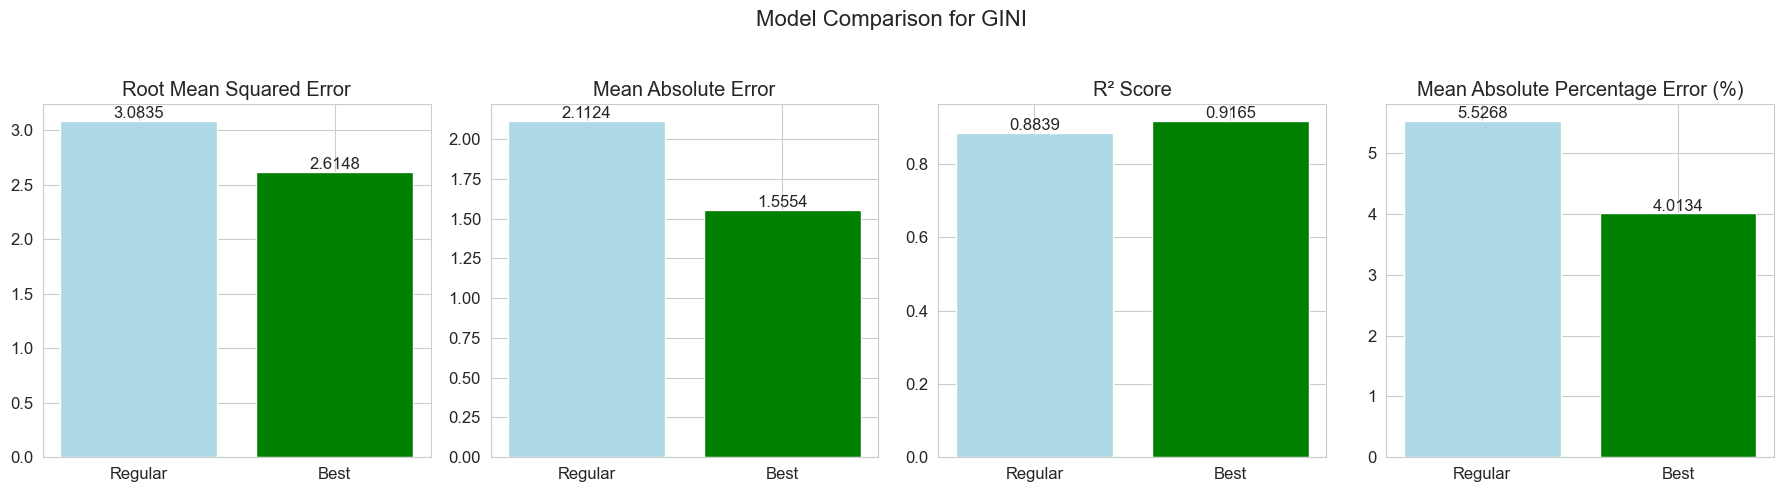

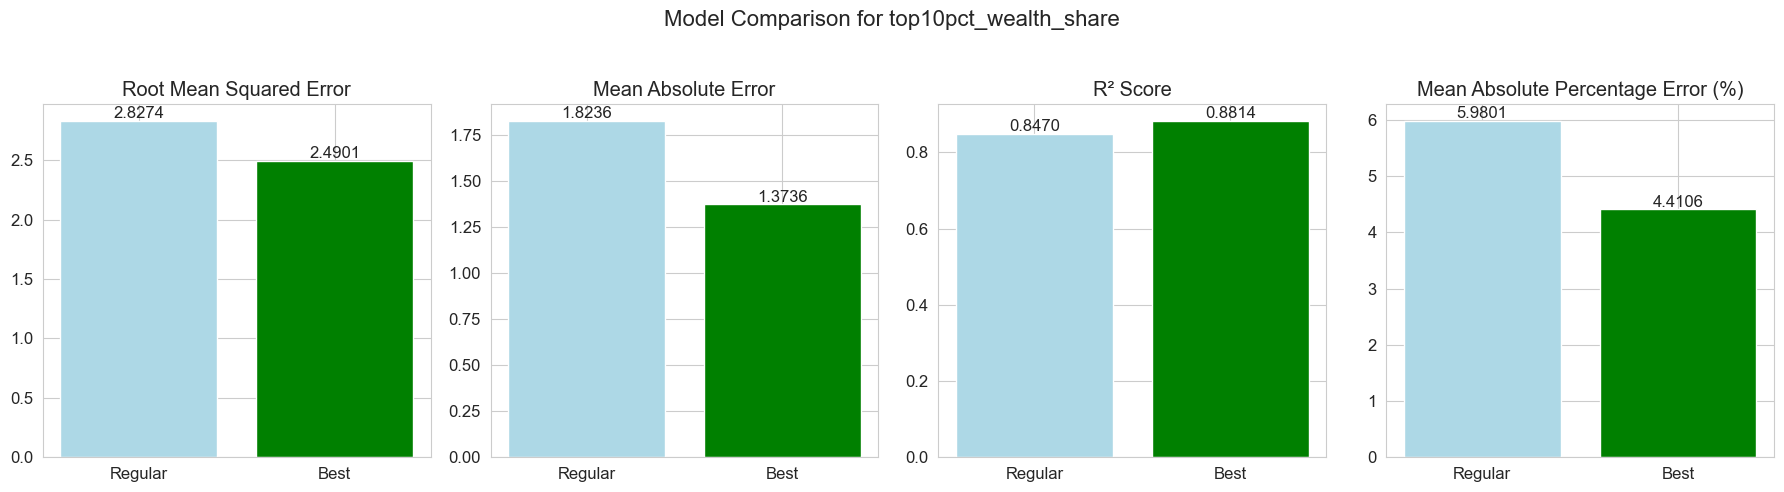

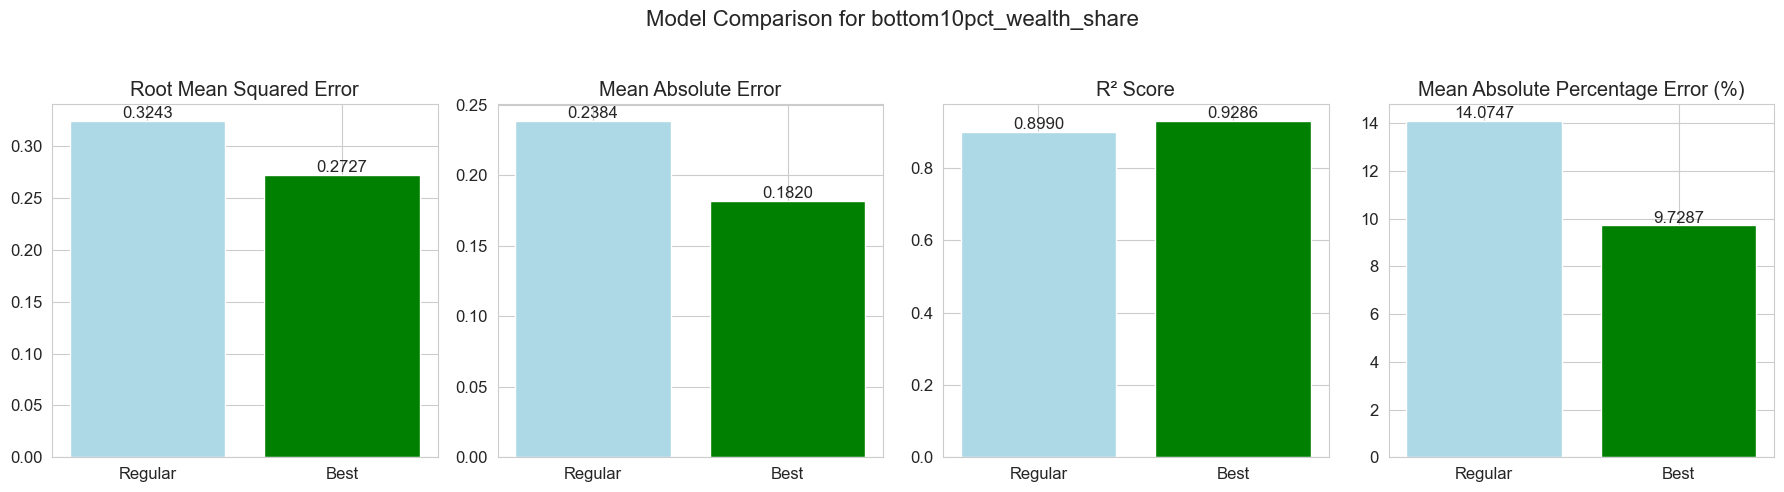

In [36]:
# Create bar charts comparing model performance metrics
def plot_model_comparison(results_df, metric_name):
    # Filter results for the specific metric
    metric_results = results_df[results_df['Metric'] == metric_name].copy()
    
    # Create subplots for each evaluation metric
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    
    eval_metrics = ['RMSE', 'MAE', 'R²', 'MAPE (%)']
    titles = ['Root Mean Squared Error', 'Mean Absolute Error', 'R² Score', 'Mean Absolute Percentage Error (%)']
    
    for i, (eval_metric, title) in enumerate(zip(eval_metrics, titles)):
        # For R², higher is better
        if eval_metric == 'R²':
            colors = ['lightblue' if x < max(metric_results[eval_metric]) else 'green' 
                     for x in metric_results[eval_metric]]
        # For others, lower is better
        else:
            colors = ['lightblue' if x > min(metric_results[eval_metric]) else 'green' 
                     for x in metric_results[eval_metric]]
        
        # Use a modified approach to create the barplot to avoid warning
        # For each model, create a separate bar without using seaborn's grouping
        x_pos = np.arange(len(metric_results['Model']))
        axes[i].bar(x_pos, metric_results[eval_metric], color=colors)
        axes[i].set_xticks(x_pos)
        axes[i].set_xticklabels(metric_results['Model'])
        axes[i].set_title(title)
        
        # Add values to bars
        for j, v in enumerate(metric_results[eval_metric]):
            axes[i].text(j, v + (v * 0.01), f"{v:.4f}", ha='center')
            
    plt.suptitle(f'Model Comparison for {metric_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
    
    return fig

# Compare models for each inequality metric
for metric in metrics:
    plot_model_comparison(results_df, metric)
    plt.show()